## Finalizing thesis diagrams

This notebook will finalize diagrams for the thesis to insure that all use the same grouping of elements. This will slice the dataframe by one year and add the diagrams.

In [1]:
# Do not modify import block, all necessary imports are included
# Our regular libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import xarray as xr
%matplotlib inline

# This is for our hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster

# For our k-means clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from sklearn import datasets
import random

# for plotting
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# this is for density plotting
from matplotlib import colorbar, colors
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
# import gsw
import math

# for the polygon intersections
import shapely.geometry as sg
import descartes

# for plotting
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
#import "/scratch/project_2000789/muramarg/miniconda3/lib/python3.10/site-packages/gsw"
import sys
 
# appending a path
sys.path.append('/scratch/project_2000789/muramarg/miniconda3/lib/python3.10/site-packages/')
 
# importing required module
import gsw

In [3]:
from scipy.interpolate import interpn


### For Cecilia

In [ ]:
# importing gsw by force
import sys
sys.path.append('/scratch/project_2000789/$USER/miniconda3/lib/python3.10/site-packages/')
import gsw

# converting ROMS values (potential T and practical S) to absolute salinity and conservative temperature
# convert depth to sea pressure
long = 73.5089
lat = -66.8245
p = gsw.p_from_z(z=depth,lat=-66.8245)

# convert the absolute salinity from practical salinity
SA = gsw.SA_from_SP(ds.variables['salt'].values,p,long,lat)    # absolute salinity from practical salinity

# convert potential T to conservative T
CT = gsw.CT_from_pt(SA,ds.variables['temp'].values)   # conservative T from potential T

# find the potential density from SA, CT, p
rho_pot = gsw.rho(SA,CT,p) - 1000

# converting back to practical salinity and potential temperature
pt = gsw.pt_from_CT(SA,CT)
SP = gsw.SP_from_SA(SA,p,long,lat)

### Add arrows to domain

### Slice the points by one year, load the release points, load the dataframe for KMeans

In [4]:
# load the libraries
ds = xr.open_dataset('/scratch/project_2000789/muramarg/waom_yearly_floats/output_WAOM_check/ocean_flt.nc')
ds1 = xr.open_dataset('/scratch/project_2000789/muramarg/waom_yearly_floats/output_WAOM_check/ocean_avg_0001.nc')
dg = xr.open_dataset('/scratch/project_2000789/muramarg/copied_files/waom10extend_grd.nc')

In [5]:
# slice the floats by one year
idx_arr = np.empty((2,5460),dtype=int)
x = ds.variables["Xgrid"].values
for i in range(idx_arr.shape[1]):
    # get the indices in that row in the xgrid
    thisrow = x[:,i]
    nonna = thisrow[~np.isnan(thisrow)]
    startidx = len(thisrow)-len(nonna)
    endidx = int(startidx + ((86400/900)*365))
    idx_arr[0][i] = startidx
    idx_arr[1][i] = endidx

# select the initial columns of values (at all times)
all_xgrid = ds.variables['Xgrid'].values
all_ygrid = ds.variables['Ygrid'].values
all_salt = ds.variables['salt'].values
all_temp = ds.variables['temp'].values
all_depth = ds.variables['depth'].values
all_dens = ds.variables['rho'].values

# create the new grids of only single year values
xgrid = np.empty((35040,5460))
ygrid = np.empty((35040,5460))
salt = np.empty((35040,5460))
temp = np.empty((35040,5460))
depth = np.empty((35040,5460))
dens = np.empty((35040,5460))

# select in the ds.xgrid and ds.ygrid based on the values in the idx_arr
for i in range(idx_arr.shape[1]):
    idxs = idx_arr[:,i]
    thisx = all_xgrid[:,i][idxs[0]:idxs[1]]
    thisy = all_ygrid[:,i][idxs[0]:idxs[1]]
    thissalt = all_salt[:,i][idxs[0]:idxs[1]]
    thistemp = all_temp[:,i][idxs[0]:idxs[1]]
    thisdept = all_depth[:,i][idxs[0]:idxs[1]]
    thisdens = all_dens[:,i][idxs[0]:idxs[1]]
    
    # add these values to our new xgrid and ygrid for one year
    xgrid[:,i] = thisx
    ygrid[:,i] = thisy
    salt[:,i] = thissalt
    temp[:,i] = thistemp
    depth[:,i] = thisdept
    dens[:,i] = thisdens

In [6]:
# convert the waom values to gsw values
# convert depth to sea pressure
long = 73.5089
lat = -66.8245
p = gsw.p_from_z(z=depth,lat=-66.8245)


# convert the absolute salinity from practical salinity
SA = gsw.SA_from_SP(salt,p,long,lat)    # absolute salinity from practical salinity

# convert potential T to conservative T
CT = gsw.CT_from_pt(SA,temp)   # conservative T from potential T

# find the potential density from SA, CT, p
rho_pot = gsw.rho(SA,CT,p) - 1000

In [7]:
# convert the absolute salinity from practical salinity
long = 73.5089
lat = -66.8245
p0 = np.zeros(depth.shape)
SA0 = gsw.SA_from_SP(salt,p0,long,lat)    # absolute salinity from practical salinity

# convert potential T to conservative T
CT0 = gsw.CT_from_pt(SA0,temp)   # conservative T from potential T
rho_pot0 = gsw.rho(SA0,CT0,p0) - 1000

In [13]:
# # get in situ T for gamman
# t = gsw.t_from_CT(SA,CT,p)
# # now gamman can be run with salt and t

In [14]:
# # add salt and t to a file to find gamman
# t.tofile("/scratch/project_2000789/muramarg/KMeans/text_files/t_gamman.txt",sep=",")
# salt.tofile("/scratch/project_2000789/muramarg/KMeans/text_files/salt_gamman.txt",sep=",")

In [10]:
# t = np.fromfile("/scratch/project_2000789/muramarg/KMeans/text_files/t_gamman.txt",sep=",")

In [7]:
# gamma_n = np.fromfile("/scratch/project_2000789/muramarg/KMeans/text_files/gamman_allpts.txt",sep=",")

In [8]:
# gamma_n = gamma_n.reshape((35040,5460))
# gamma_n = gamma_n + 1000

In [8]:
# residence time
xbins = np.r_[0:630:1]
ybins = np.r_[0:560:1]

# index of bins the particles ending in
x_new = np.digitize(xgrid,xbins)
y_new = np.digitize(ygrid,ybins)

In [6]:
# # test reading the file
with open("/scratch/project_2000789/muramarg/KMeans/text_files/wm_file_year4.txt","r") as f:
# # with open("wm_alter.txt","r") as f:
    a = f.readlines()
    wm_arr = np.empty((35040,5460))
    for i in range(35040):
        b = a[i].split(" ")
        b = np.asarray(b)
        b[-1] = b[-1][:-1]
        b = b.astype(int)
        wm_arr[i] = b
f.close()

In [7]:
wm_arr[wm_arr == 6] = 3
wm_arr[wm_arr == 7] = 2
# wmt = wmt[wmt == 8] = 6

In [8]:
wm_arr[wm_arr == 8] = 6

In [14]:
# unique_elements, counts_elements = np.unique(wmt[-1], return_counts=True)
# print(unique_elements,counts_elements)

[0. 1. 2. 3. 4. 5. 6.] [1287 1917  637  344  606  599   70]


## Make an animation

In [12]:
lat_values = dg.lat_rho.values
long_values = dg.lon_rho.values

In [13]:
xbins = np.r_[0:630:1]
ybins = np.r_[0:560:1]
[Xbins, Ybins] = np.meshgrid(ybins,xbins)

In [14]:
stack = np.stack((ygrid, xgrid), axis=-1)
stack.shape

(35040, 5460, 2)

In [15]:
# stack = np.stack((all_ygrid, all_xgrid), axis=-1)
# stack = np.nan_to_num(stack, copy=True, nan=0)

In [16]:
# x = interpn((xbins,ybins),lat,np.append(xgrid,xgrid).reshape(35040,5460,2).flatten())
# y = interpn((xbins,ybins),long,np.append(ygrid,ygrid).reshape(35040,5460,2).flatten())
lat2 = interpn((ybins,xbins),lat_values,stack)
long2 = interpn((ybins,xbins),long_values,stack)
#long2 = interpn((ybins,xbins),long_values,stack)

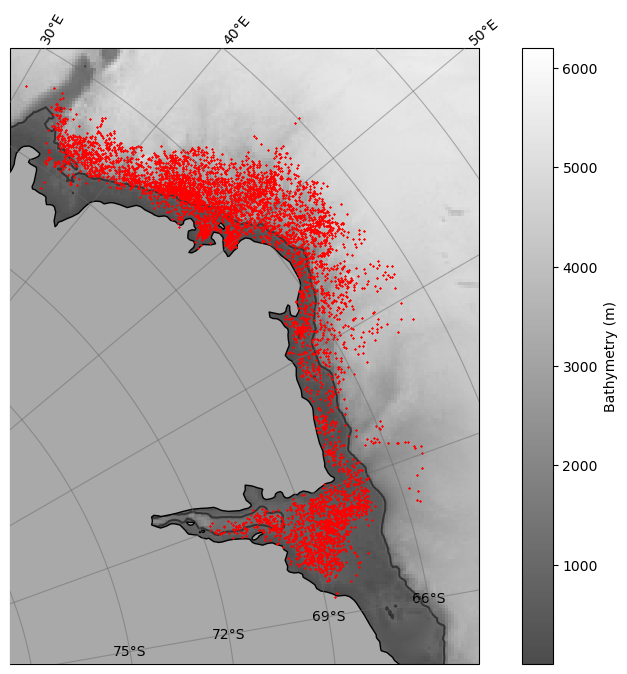

In [30]:

# plot all the groups colored by the water mass grid
proj = ccrs.SouthPolarStereo(central_longitude=0.0, true_scale_latitude=None, globe=None)
fig = plt.figure(figsize=(11,8))
ax = fig.add_subplot(1, 1, 1,projection=proj)

# add the points
plt.scatter(long2[35035],lat2[35035],transform=ccrs.PlateCarree(),color="red",s=0.5,zorder=10,marker='x')
#plt.plot(long2[:100],lat2[:100],marker = '.',markersize=1, color='red',transform=ccrs.PlateCarree(),zorder=9,alpha=0.6)

#plt.plot(xgrid[0],ygrid[0],'o',markersize=0.1,c="blue",zorder=10,transform=ccrs.PlateCarree())
plt.pcolormesh(dg.lon_rho,dg.lat_rho,ds1.h.isel(),transform=ccrs.PlateCarree(),cmap=plt.get_cmap('gray'),alpha=0.7)
cbar = plt.colorbar()
cbar.set_label('Bathymetry (m)')
plt.grid()
ax.coastlines(zorder=5,facecolor='white',edgecolor='white')
cs = plt.contour(dg.lon_rho[300:,350:], dg.lat_rho[300:,350:],dg.h[300:,350:],levels=[1000],zorder=2, linestyles='solid', transform=ccrs.PlateCarree(), colors="black",alpha=0.5)
ax = plt.gca()
ax.gridlines(draw_labels=True,zorder=10,color="dimgray",alpha=0.5,transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND,facecolor='darkgray',zorder=3)
plt.xlim([1250000,2850000])
plt.ylim([250000,2350000])

# make the string to save the points
plt.savefig("/scratch/project_2000789/muramarg/KMeans/formeeting_328/animation35035.png", dpi=300)

## Plot the 2x2 residence time diagrams and density map

In [44]:
# residence time
xbins = np.r_[0:630:1]
ybins = np.r_[0:560:1]

# index of bins the particles ending in
x_new = np.digitize(xgrid,xbins)
y_new = np.digitize(ygrid,ybins)

# create an empty array for the bin time
m2 = []
for i in range(len(xbins)):
    newl = []
    for j in range(len(ybins)):
        newl.append([])
    m2.append(newl)
    
# each bin has an average or total time that any one particle spends in it
# for each column
start_time = time.time()
for i in range(x_new.shape[1]):
#for i in range(5):
    if i % 1000 == 0:
        print(i,'of',x_new.shape[1],'in',(time.time()-start_time)/60)
    # get the x and y column values
    thisx = x_new[:,i]
    thisy = y_new[:,i]

    # make a stack of the x and y columns
    pts = np.vstack((thisx,thisy))
    pts = pts.T

    # normalize to the total number of particles
    counts = list(zip(*np.unique(pts, return_counts = True, axis = 0)))
    counts.pop()
    
    # add each count to a list in the mesh
    for ii in counts[:-1]:
        iind = ii[0][0]
        jind = ii[0][1]
        
        # create the mesh without the scaling by time
        myval = (ii[1]*900)/86400 # current sum of the column totals

        # see if the current number of the mesh is zero, if it is, add to list
        #print(m2[iind][jind])
        
        m2[int(iind)][int(jind)].append(myval)

0 of 5460 in 2.8332074483235676e-06
1000 of 5460 in 0.3651299118995667
2000 of 5460 in 0.7288013696670532
3000 of 5460 in 1.1084315458933511
4000 of 5460 in 1.4802799622217815
5000 of 5460 in 1.8450784921646117


In [45]:
# AVERAGE MESH
mesh = np.zeros((len(xbins),len(ybins)))

# create the mesh based on averages of m2
for ii in range(len(m2)):
    for jj in range(len(m2[ii])):
        if len(m2[ii][jj])>0:
            avg = sum(m2[ii][jj])/len(m2[ii][jj])
            if avg<200:
                mesh[ii][jj] = avg
            #else:
                #print(avg)
                
# MAX MESH
mesh_max = np.zeros((len(xbins),len(ybins)))
# create the mesh based on maximum values of m2
for ii in range(len(m2)):
    for jj in range(len(m2[ii])):
        if len(m2[ii][jj])>0:
            avg = max(m2[ii][jj])
            #print(avg)
            mesh_max[ii][jj] = avg
            #else:
            #    print(avg)

# MIN MESH
mesh_min = np.zeros((len(xbins),len(ybins)))
# create the mesh based on maximum values of m2
for ii in range(len(m2)):
    for jj in range(len(m2[ii])):
        if len(m2[ii][jj])>0:
            avg = min(m2[ii][jj])
            if avg<200:
                mesh_min[ii][jj] = avg
            #else:
            #    print(avg)

# STDEV MESH
mesh_std = np.zeros((len(xbins),len(ybins)))
# create the mesh based on maximum values of m2
for ii in range(len(m2)):
    for jj in range(len(m2[ii])):
        if len(m2[ii][jj])>0:
            avg = np.std(m2[ii][jj])
            #if avg<200:
            mesh_std[ii][jj] = avg
            
[Xbins, Ybins] = np.meshgrid(ybins,xbins)
print(Xbins.shape)

# write the mesh to a text file
# # transform the Ybins and Xbins into lat/long points
lat_values = dg.lat_rho.values
long_values = dg.lon_rho.values
print(lat_values.shape)
lat = np.array([])
long = np.array([])

# # interpolate in latitude
x_shape = np.arange(dg.lat_rho.shape[0])
y_shape = np.arange(dg.lat_rho.shape[1])
# for each row
for i,j in zip(Xbins,Ybins):
    # for each column create the long and lat values
    row_long = np.array([])
    row_lat = np.array([])
    
    for a,b in zip(i,j):
        interp_x = a
        interp_y = b
        # interpolate in longitude
        thislong = long_values[interp_x,interp_y]
        # interpolate in latitude
        thislat = lat_values[interp_x,interp_y]
        
        row_long = np.append(row_long,thislong)
        row_lat = np.append(row_lat,thislat)
    
    if len(lat) == 0:
        lat = np.append(lat,row_lat)
        long = np.append(long,row_long)
    else:
        lat = np.vstack((lat,row_lat))
        long = np.vstack((long,row_long))

(630, 560)
(560, 630)


In [53]:
print(np.where(mesh == np.amax(mesh)))
print(np.amax(mesh))

(array([529]), array([346]))
74.67013888888889


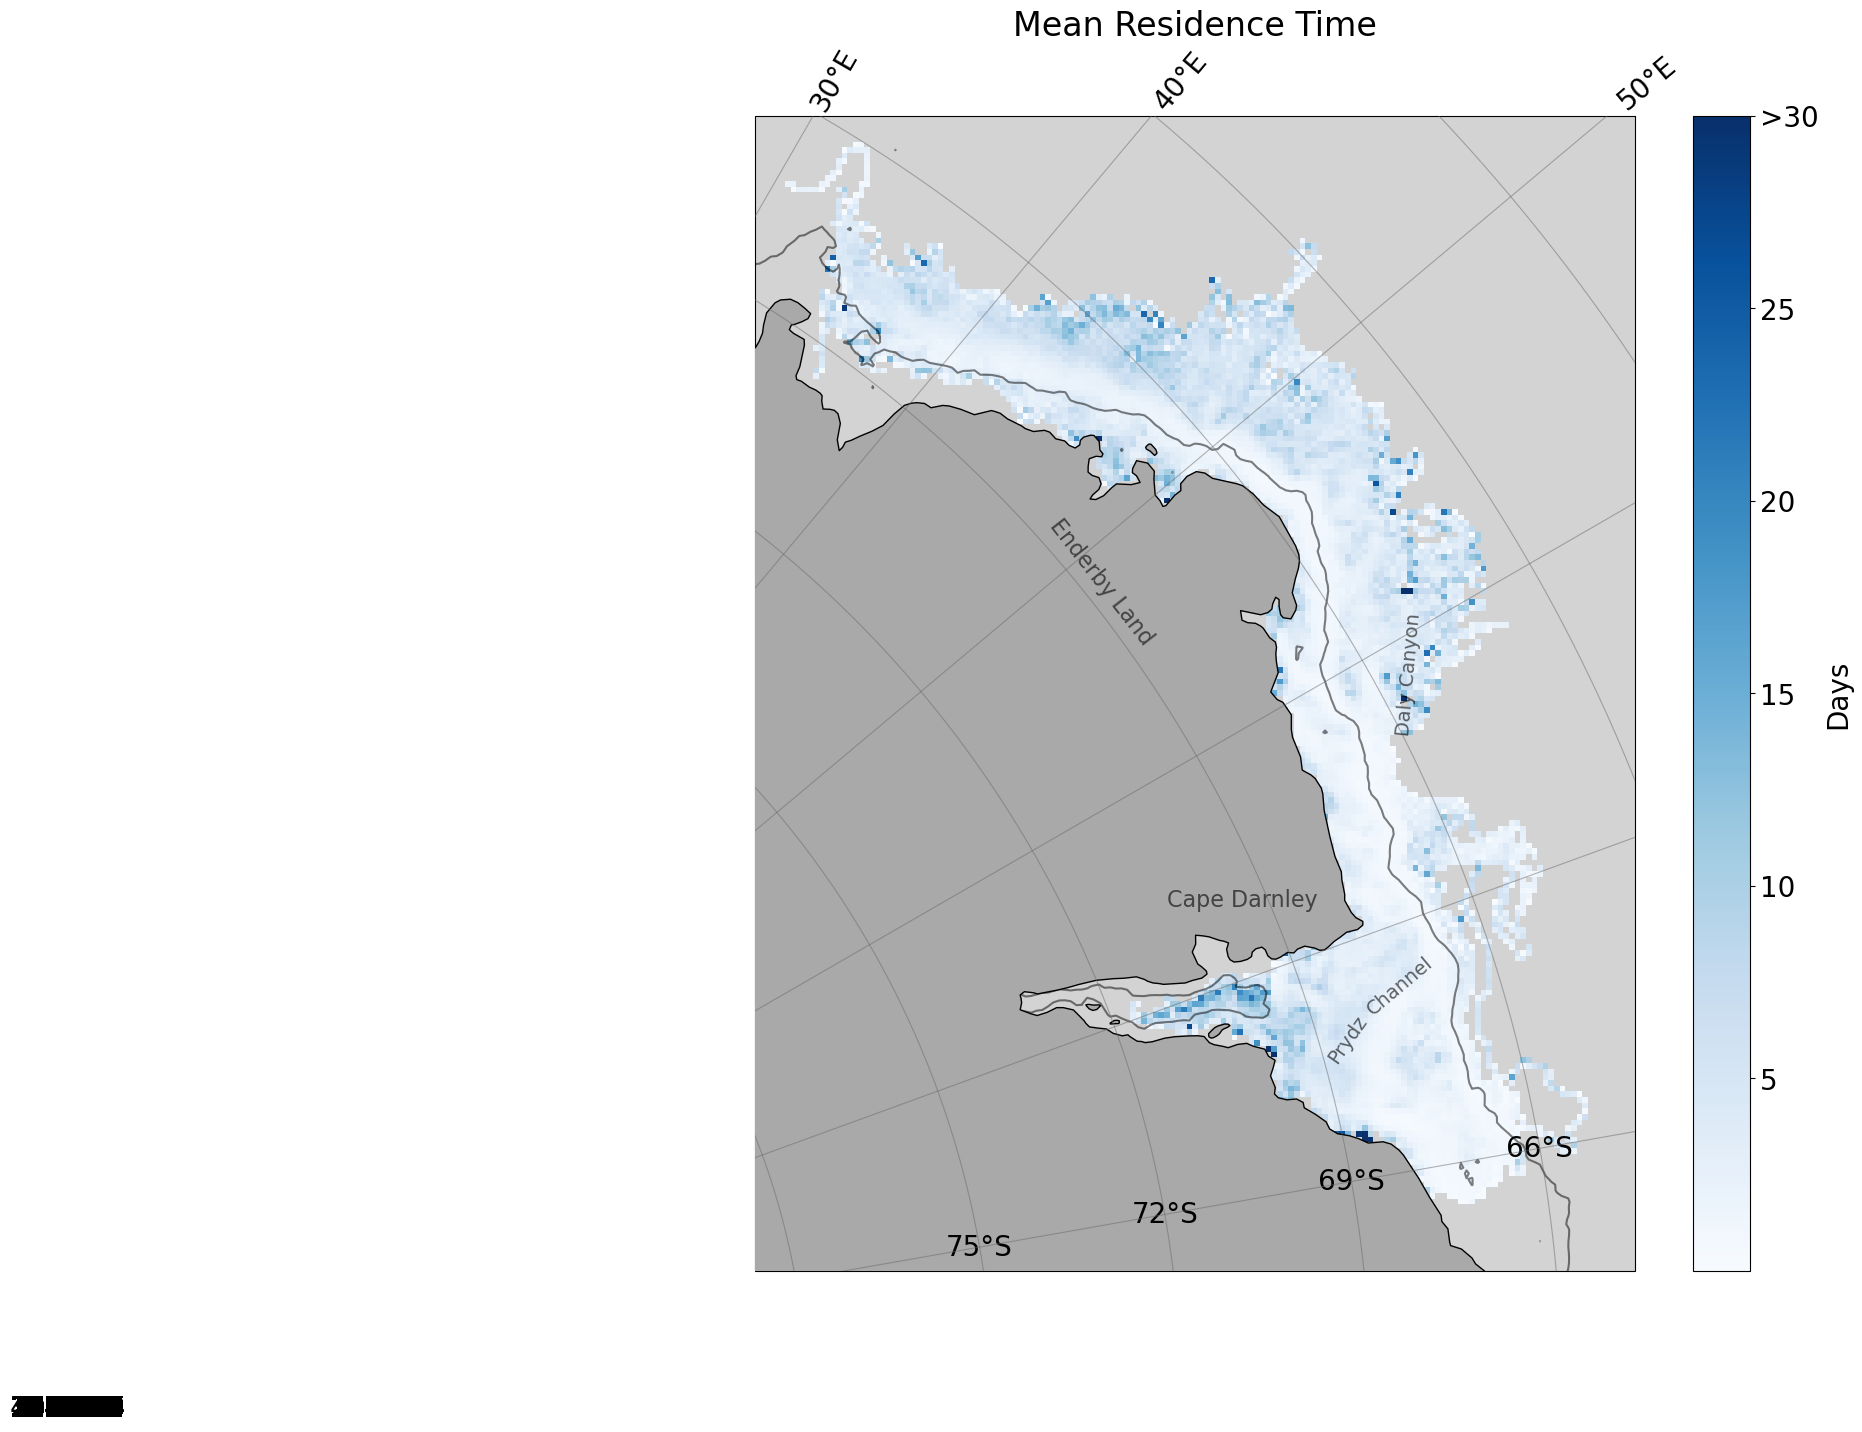

In [27]:
# FOR PRESENTATION
# average values
proj = ccrs.SouthPolarStereo(central_longitude=0.0, true_scale_latitude=None, globe=None)
fig = plt.figure(figsize=(15,15))

ax = fig.add_subplot(1, 1, 1, projection=proj) 
ax.coastlines(zorder=5,facecolor='white',edgecolor='white')
plt.xlim([1250000,2850000])
plt.ylim([250000,2350000])
cs = plt.contour(dg.lon_rho[300:,350:], dg.lat_rho[300:,350:],dg.h[300:,350:],levels=[1000],zorder=2, linestyles='solid', transform=ccrs.PlateCarree(), colors="black",alpha=0.5)
plt.rcParams.update({'font.size': 20})
ax = plt.gca()
ax.gridlines(draw_labels=True,zorder=10,color="dimgray",alpha=0.5)
ax.add_feature(cfeature.LAND,facecolor='darkgray',zorder=3)
cmap = mpl.cm.get_cmap("Blues").copy()
cmap.set_under(color='lightgray')
plt.pcolormesh(long[420:580,300:530],lat[420:580,300:530],mesh[420:580,300:530],transform=ccrs.PlateCarree(),zorder=1,cmap=cmap,vmin=0.0000001,vmax=30)
plt.title("Mean Residence Time")
cbar = plt.colorbar(ticks=[5,10,15,20,25,30],label="Days")
cbar.ax.set_yticklabels(["5","10","15","20","25",">30"])  # vertically oriented colorbar
plt.text(x=52, y=-70,s="Enderby Land",transform=ccrs.PlateCarree(),rotation=-52,fontsize=16,alpha=0.6)
plt.text(x=65.5, y=-70.5,s="Cape Darnley",transform=ccrs.PlateCarree(),rotation=0,fontsize=16,alpha=0.6)
plt.text(x=74.6, y=-69,s="Prydz",transform=ccrs.PlateCarree(),rotation=-305,fontsize=14,alpha=0.6)
plt.text(x=73.1, y=-68.2,s="Channel",transform=ccrs.PlateCarree(),rotation=-320,fontsize=14,alpha=0.6)
plt.text(x=63, y=-66.1,s="Daly Canyon",transform=ccrs.PlateCarree(),rotation=-275,fontsize=14,alpha=0.6)

# add the labels for plotting

for y in range(mesh.shape[0]):
    for x in range(mesh.shape[1]):
        plt.text(x + 0.5, y + 0.5, '%.4f' % mesh[y, x],
                 horizontalalignment='center',
                 verticalalignment='center',
                 )

#plt.savefig('/scratch/project_2000789/muramarg/KMeans/formeeting_328/mean_res_time.png',dpi=300)

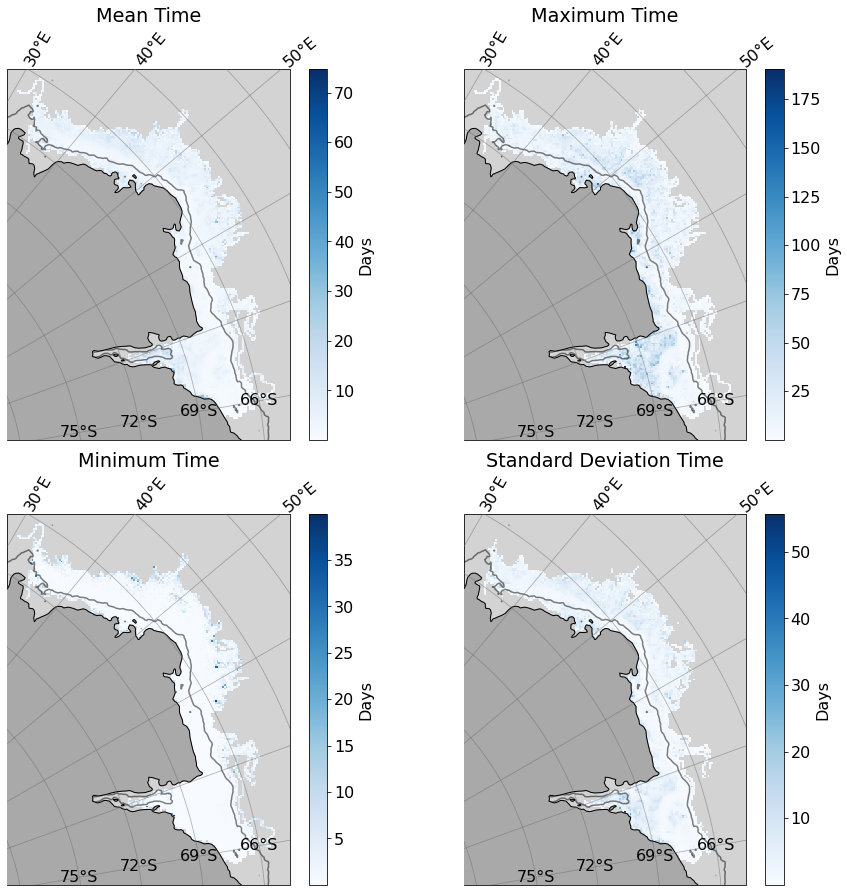

In [323]:
# FOR PRESENTATION
# average values
proj = ccrs.SouthPolarStereo(central_longitude=0.0, true_scale_latitude=None, globe=None)
fig = plt.figure(figsize=(15,15))

ax = fig.add_subplot(2, 2, 1, projection=proj) 
ax.coastlines(zorder=5,facecolor='white',edgecolor='white')
plt.xlim([1250000,2850000])
plt.ylim([250000,2350000])
cs = plt.contour(dg.lon_rho[300:,350:], dg.lat_rho[300:,350:],dg.h[300:,350:],levels=[1000],zorder=2, linestyles='solid', transform=ccrs.PlateCarree(), colors="black",alpha=0.5)
plt.rcParams.update({'font.size': 16})
ax = plt.gca()
ax.gridlines(draw_labels=True,zorder=10,color="dimgray",alpha=0.5)
ax.add_feature(cfeature.LAND,facecolor='darkgray',zorder=3)
cmap = mpl.cm.get_cmap("Blues").copy()
cmap.set_under(color='lightgray')
plt.pcolormesh(long[420:580,300:530],lat[420:580,300:530],mesh[420:580,300:530],transform=ccrs.PlateCarree(),zorder=1,cmap=cmap,vmin=0.0000001)
plt.title("Mean Time")
plt.colorbar(label="Days")

ax = fig.add_subplot(2, 2, 2, projection=proj) 
ax.coastlines(zorder=5,facecolor='white',edgecolor='white')
plt.xlim([1250000,2850000])
plt.ylim([250000,2350000])
cs = plt.contour(dg.lon_rho[300:,350:], dg.lat_rho[300:,350:],dg.h[300:,350:],levels=[1000],zorder=2, linestyles='solid', transform=ccrs.PlateCarree(), colors="black",alpha=0.5)
plt.rcParams.update({'font.size': 16})
ax = plt.gca()
ax.gridlines(draw_labels=True,zorder=10,color="dimgray",alpha=0.5)
ax.add_feature(cfeature.LAND,facecolor='darkgray',zorder=3)
cmap = mpl.cm.get_cmap("Blues").copy()
cmap.set_under(color='lightgray')
plt.pcolormesh(long[420:580,300:530],lat[420:580,300:530],mesh_max[420:580,300:530],transform=ccrs.PlateCarree(),zorder=1,cmap=cmap,vmin=0.0000001)
plt.title("Maximum Time")
plt.colorbar(label="Days")

ax = fig.add_subplot(2, 2, 3, projection=proj) 
ax.coastlines(zorder=5,facecolor='white',edgecolor='white')
plt.xlim([1250000,2850000])
plt.ylim([250000,2350000])
cs = plt.contour(dg.lon_rho[300:,350:], dg.lat_rho[300:,350:],dg.h[300:,350:],levels=[1000],zorder=2, linestyles='solid', transform=ccrs.PlateCarree(), colors="black",alpha=0.5)
plt.rcParams.update({'font.size': 16})
ax = plt.gca()
ax.gridlines(draw_labels=True,zorder=10,color="dimgray",alpha=0.5)
ax.add_feature(cfeature.LAND,facecolor='darkgray',zorder=3)
cmap = mpl.cm.get_cmap("Blues").copy()
cmap.set_under(color='lightgray')
plt.pcolormesh(long[420:580,300:530],lat[420:580,300:530],mesh_min[420:580,300:530],transform=ccrs.PlateCarree(),zorder=1,cmap=cmap,vmin=0.0000001)
plt.title("Minimum Time")
plt.colorbar(label="Days")

ax = fig.add_subplot(2, 2, 4, projection=proj) 
ax.coastlines(zorder=5,facecolor='white',edgecolor='white')
plt.xlim([1250000,2850000])
plt.ylim([250000,2350000])
cs = plt.contour(dg.lon_rho[300:,350:], dg.lat_rho[300:,350:],dg.h[300:,350:],levels=[1000],zorder=2, linestyles='solid', transform=ccrs.PlateCarree(), colors="black",alpha=0.5)
plt.rcParams.update({'font.size': 16})
ax = plt.gca()
ax.gridlines(draw_labels=True,zorder=10,color="dimgray",alpha=0.5)
ax.add_feature(cfeature.LAND,facecolor='darkgray',zorder=3)
cmap = mpl.cm.get_cmap("Blues").copy()
cmap.set_under(color='lightgray')
plt.pcolormesh(long[420:580,300:530],lat[420:580,300:530],mesh_std[420:580,300:530],transform=ccrs.PlateCarree(),zorder=1,cmap=cmap,vmin=0.0000001)
plt.title("Standard Deviation Time")
plt.colorbar(label="Days")

plt.savefig('/scratch/project_2000789/muramarg/KMeans/formeeting_328/res_time4.png',dpi=300)

In [54]:
# create the density map
x_sing = np.array([])
y_sing = np.array([])
start_time = time.time()
for col in range(x_new.shape[1]):
    if col % 500 == 0:
        print(col,'of',x_new.shape[1],'in',(time.time()-start_time)/60)
    # create a set of datapoints
    thisx = (x_new[:,col])
    thisy = (y_new[:,col])
    
    # create the array of the colum
    arr = np.vstack((thisx,thisy))
    arr = arr.T
    
    # create a set from the array so each coordinate visits each grid square once
    set_coords = list(set(map(tuple,arr)))
    for myset in set_coords:
        x_sing = np.append(x_sing,myset[0])
        y_sing = np.append(y_sing,myset[1])
        
pts = np.vstack((x_sing,y_sing))
pts = pts.T

# normalize to the total number of particles
counts = list(zip(*np.unique(pts, return_counts = True, axis = 0)))
num_positions = len(counts)
#print(counts)
print(num_positions)

# pop the nan values
counts.pop()

# we are dividing by the number of particles, not number of positions
num_particles = 5460
print(num_particles)

mesh = np.zeros((len(xbins),len(ybins)))

for ii in counts[:-1]:
    iind = ii[0][0]
    jind = ii[0][1]
    # create the mesh without the scaling by time
    myval = ii[1]/num_particles
    
    # scale by time for one day
    myval = (myval/900)*86400
    
    mesh[int(iind)][int(jind)] = myval
    
    # 
mesh

[Xbins, Ybins] = np.meshgrid(ybins,xbins)
print(Xbins.shape)

# # transform the Ybins and Xbins into lat/long points
lat_values = dg.lat_rho.values
long_values = dg.lon_rho.values
print(lat_values.shape)
lat = np.array([])
long = np.array([])

# # interpolate in latitude
x_shape = np.arange(dg.lat_rho.shape[0])
y_shape = np.arange(dg.lat_rho.shape[1])
# for each row
for i,j in zip(Xbins,Ybins):
    # for each column create the long and lat values
    row_long = np.array([])
    row_lat = np.array([])
    
    for a,b in zip(i,j):
        interp_x = a
        interp_y = b
        # interpolate in longitude
        thislong = long_values[interp_x,interp_y]
        # interpolate in latitude
        thislat = lat_values[interp_x,interp_y]
        
        row_long = np.append(row_long,thislong)
        row_lat = np.append(row_lat,thislat)
    
    if len(lat) == 0:
        lat = np.append(lat,row_lat)
        long = np.append(long,row_long)
    else:
        lat = np.vstack((lat,row_lat))
        long = np.vstack((long,row_long))

0 of 5460 in 1.7841657002766927e-06
500 of 5460 in 0.2742136279741923
1000 of 5460 in 0.8769145806630453
1500 of 5460 in 1.7439167102177937
2000 of 5460 in 2.9058497190475463
2500 of 5460 in 4.49282503525416
3000 of 5460 in 6.286433486143748
3500 of 5460 in 8.424454581737518
4000 of 5460 in 10.925767083962759
4500 of 5460 in 13.540766068299611
5000 of 5460 in 16.50828358332316
6534
5460
(630, 560)
(560, 630)


In [55]:
print(np.where(mesh == np.amax(mesh)))
print(np.amax(mesh))

(array([528]), array([409]))
43.35824175824175


In [ ]:
fig = plt.figure(figsize=(15,15))
heatmap = plt.pcolor(mesh)

for y in range(mesh.shape[0]):
    for x in range(mesh.shape[1]):
        plt.text(x + 0.5, y + 0.5, '%.4f' % mesh[y, x],
                 horizontalalignment='center',
                 verticalalignment='center',
                 )

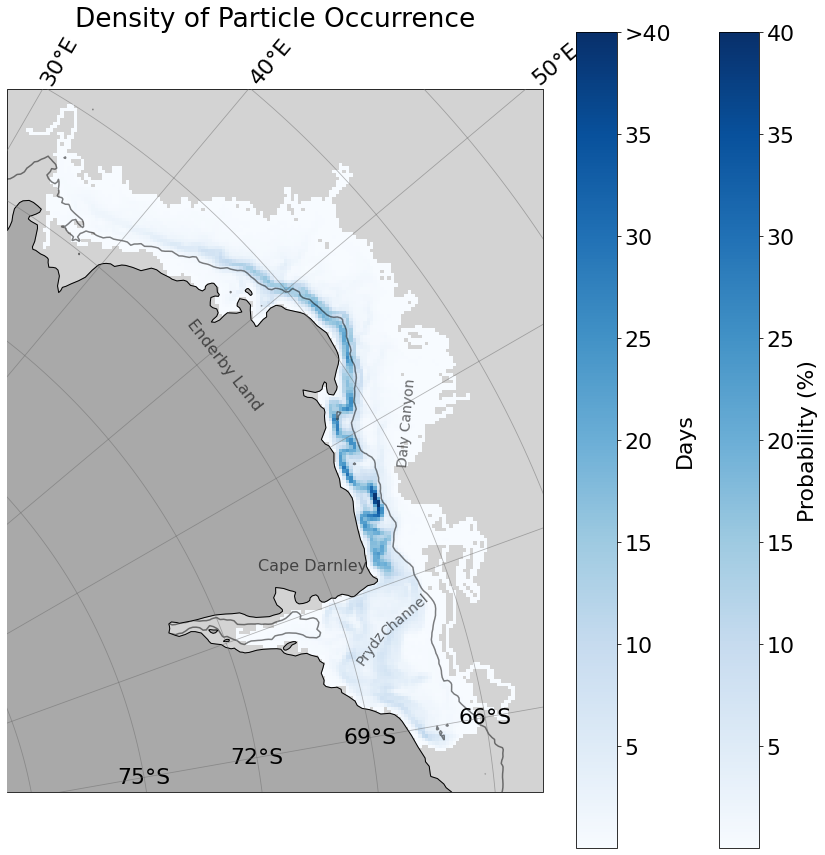

In [19]:
proj = ccrs.SouthPolarStereo(central_longitude=0.0, true_scale_latitude=None, globe=None)
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(1, 1, 1, projection=proj) 
ax.coastlines(zorder=5,facecolor='white',edgecolor='white')
plt.xlim([1250000,2850000])
plt.ylim([250000,2350000])
# xlimit = np.arange(300,500,1)
# ylimit = np.arange(450,630,1)
#a = plt.contour(dg.lon_rho[470:500,400:410], dg.lat_rho[470:500,400:410],ds1.zice[70:500,400:410],levels=[-0.2],zorder=2,linestyles='dashed', transform=ccrs.PlateCarree(), cmap=plt.cm.binary)
#b = plt.contour(dg.lon_rho[470:,400:410], dg.lat_rho[470:,400:410],ds1.h[470:,400:],levels=[1000],zorder=2, linestyles='solid', transform=ccrs.PlateCarree(), cmap=plt.cm.binary)

cs = plt.contour(dg.lon_rho[300:,350:], dg.lat_rho[300:,350:],dg.h[300:,350:],levels=[1000],zorder=2, linestyles='solid', transform=ccrs.PlateCarree(), colors="black",alpha=0.5)
#plt.contour(p[-1])
#plt.contour(v)

plt.rcParams.update({'font.size': 22})

ax = plt.gca()
ax.gridlines(draw_labels=True,zorder=10,color="dimgray",alpha=0.5)
ax.add_feature(cfeature.LAND,facecolor='darkgray',zorder=3)

cmap = mpl.cm.get_cmap("Blues").copy()
cmap.set_under(color='lightgray')
#plt.contour(v,transform=ccrs.PlateCarree())


plt.pcolormesh(long[420:580,300:530],lat[420:580,300:530],mesh[420:580,300:530],transform=ccrs.PlateCarree(),zorder=1,cmap=cmap,vmin=0.0000001,vmax=40)
plt.title("Density of Particle Occurrence")
cbar = plt.colorbar(ticks=[5,10,15,20,25,30,35,40],label="Probability (%)")
cbar.ax.set_yticklabels(["5","10","15","20","25","30","35",">40"])  # vertically oriented colorbar

plt.text(x=52, y=-70,s="Enderby Land",transform=ccrs.PlateCarree(),rotation=-52,fontsize=16,alpha=0.6)
plt.text(x=65.5, y=-70.5,s="Cape Darnley",transform=ccrs.PlateCarree(),rotation=0,fontsize=16,alpha=0.6)
plt.text(x=74.6, y=-69,s="Prydz",transform=ccrs.PlateCarree(),rotation=-305,fontsize=14,alpha=0.6)
plt.text(x=73.1, y=-68.2,s="Channel",transform=ccrs.PlateCarree(),rotation=-320,fontsize=14,alpha=0.6)
plt.text(x=63, y=-66.1,s="Daly Canyon",transform=ccrs.PlateCarree(),rotation=-275,fontsize=14,alpha=0.6)

#plt.xlim()
plt.savefig('/scratch/project_2000789/muramarg/KMeans/formeeting_328/method2_writing.png')

In [ ]:
# test heatmat
import seaborn as sns

proj = ccrs.SouthPolarStereo(central_longitude=0.0, true_scale_latitude=None, globe=None)
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(1, 1, 1, projection=proj) 
ax.coastlines(zorder=5,facecolor='white',edgecolor='white')
plt.xlim([1250000,2850000])
plt.ylim([250000,2350000])
# xlimit = np.arange(300,500,1)
# ylimit = np.arange(450,630,1)
#a = plt.contour(dg.lon_rho[470:500,400:410], dg.lat_rho[470:500,400:410],ds1.zice[70:500,400:410],levels=[-0.2],zorder=2,linestyles='dashed', transform=ccrs.PlateCarree(), cmap=plt.cm.binary)
#b = plt.contour(dg.lon_rho[470:,400:410], dg.lat_rho[470:,400:410],ds1.h[470:,400:],levels=[1000],zorder=2, linestyles='solid', transform=ccrs.PlateCarree(), cmap=plt.cm.binary)

cs = plt.contour(dg.lon_rho[300:,350:], dg.lat_rho[300:,350:],dg.h[300:,350:],levels=[1000],zorder=2, linestyles='solid', transform=ccrs.PlateCarree(), colors="black",alpha=0.5)
#plt.contour(p[-1])
#plt.contour(v)

plt.rcParams.update({'font.size': 22})

ax = plt.gca()
ax.gridlines(draw_labels=True,zorder=10,color="dimgray",alpha=0.5)
ax.add_feature(cfeature.LAND,facecolor='darkgray',zorder=3)

cmap = mpl.cm.get_cmap("Blues").copy()
cmap.set_under(color='lightgray')
#plt.contour(v,transform=ccrs.PlateCarree())


plt.pcolormesh(long[420:580,300:530],lat[420:580,300:530],mesh[420:580,300:530],transform=ccrs.PlateCarree(),zorder=1,cmap=cmap,vmin=0.0000001,vmax=40)
plt.title("Density of Particle Occurrence")
cbar = plt.colorbar(ticks=[5,10,15,20,25,30,35,40],label="Probability (%)")
cbar.ax.set_yticklabels(["5","10","15","20","25","30","35",">40"])  # vertically oriented colorbar

plt.text(x=52, y=-70,s="Enderby Land",transform=ccrs.PlateCarree(),rotation=-52,fontsize=16,alpha=0.6)
plt.text(x=65.5, y=-70.5,s="Cape Darnley",transform=ccrs.PlateCarree(),rotation=0,fontsize=16,alpha=0.6)
plt.text(x=74.6, y=-69,s="Prydz",transform=ccrs.PlateCarree(),rotation=-305,fontsize=14,alpha=0.6)
plt.text(x=73.1, y=-68.2,s="Channel",transform=ccrs.PlateCarree(),rotation=-320,fontsize=14,alpha=0.6)
plt.text(x=63, y=-66.1,s="Daly Canyon",transform=ccrs.PlateCarree(),rotation=-275,fontsize=14,alpha=0.6)

#plt.xlim()
plt.savefig('/scratch/project_2000789/muramarg/KMeans/formeeting_328/method2_writing.png')

## Polynya Locations

In [11]:
# show the release points with bathymetry
with open("/users/muramarg/points.txt","r") as f:
    lines = f.readlines()
f.close()
lines = lines[2:]
xfirst = np.array([])
yfirst = np.array([])
for i in range(len(lines)):
    xi = float(lines[i][:5])
    yi = float(lines[i][-6:-1])
    xfirst = np.append(xfirst,xi)
    yfirst = np.append(yfirst,yi)

(250000.0, 2350000.0)

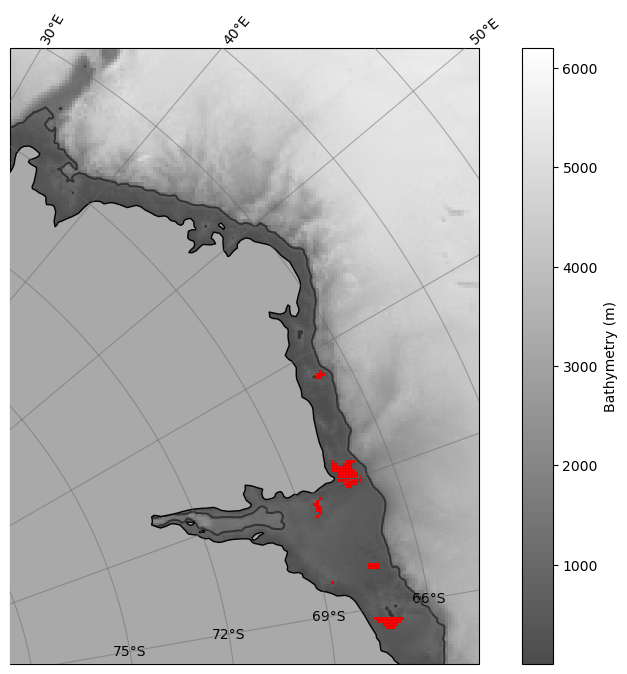

In [32]:
# THESE ARE IN GRID POINTS
# plot all the groups colored by the water mass grid
proj = ccrs.SouthPolarStereo(central_longitude=0.0, true_scale_latitude=None, globe=None)
fig = plt.figure(figsize=(11,8))
ax = fig.add_subplot(1, 1, 1,projection=proj)

# add the points
plt.scatter(long2[0],lat2[0],transform=ccrs.PlateCarree(),color="red",s=0.1,zorder=10,marker='o')
#plt.plot(long2[:100],lat2[:100],marker = '.',markersize=1, color='red',transform=ccrs.PlateCarree(),zorder=9,alpha=0.6)

#plt.plot(xgrid[0],ygrid[0],'o',markersize=0.1,c="blue",zorder=10,transform=ccrs.PlateCarree())
plt.pcolormesh(dg.lon_rho,dg.lat_rho,ds1.h.isel(),transform=ccrs.PlateCarree(),cmap=plt.get_cmap('gray'),alpha=0.7)
cbar = plt.colorbar()
cbar.set_label('Bathymetry (m)')
plt.grid()
ax.coastlines(zorder=5,facecolor='white',edgecolor='white')
cs = plt.contour(dg.lon_rho[300:,350:], dg.lat_rho[300:,350:],dg.h[300:,350:],levels=[1000],zorder=2, linestyles='solid', transform=ccrs.PlateCarree(), colors="black",alpha=0.5)
ax = plt.gca()
ax.gridlines(draw_labels=True,zorder=10,color="dimgray",alpha=0.5,transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND,facecolor='darkgray',zorder=3)
plt.xlim([1250000,2850000])
plt.ylim([250000,2350000])

# add the polygons for polynya shapes
# BARRIER: x[540:560], y[330:342]
# sx = np.array([541,555,555,541])
# sy = np.array([334,334,341,341])
# b = np.array([[a,b] for a,b in zip(sx,sy)])
# barrier = sg.Polygon(b)
# barrier1 = ax.add_patch(descartes.PolygonPatch(barrier, fc='none', ec='blue', alpha=1,label="Barrier"))

# # DARNLEY: x[525:540], y[380:400]
# sx = np.array([527,538,538,527])
# sy = np.array([381,381,395,395])
# d = np.array([[a,b] for a,b in zip(sx,sy)])
# darnley = sg.Polygon(d)
# darnley1 = ax.add_patch(descartes.PolygonPatch(darnley, fc='none', ec='green', alpha=1,label="Darnley"))

# # DAVIS: x[525:530], y[345:355]
# sx = np.array([525,530,530,525])
# sy = np.array([346,346,355,355])
# da = np.array([[a,b] for a,b in zip(sx,sy)])
# davis = sg.Polygon(da)
# davis1 = ax.add_patch(descartes.PolygonPatch(davis, fc='none', ec='orange', alpha=1,label="Davis"))

# # MACKENZIE: x[520:530], y[370,380]
# sx = np.array([521,526,526,521])
# sy = np.array([370,370,381,381])
# m = np.array([[a,b] for a,b in zip(sx,sy)])
# mackenzie = sg.Polygon(m)
# mackenzie1 = ax.add_patch(descartes.PolygonPatch(mackenzie, fc='none', ec='purple', alpha=1,label="MacKenzie"))

# ax = plt.gca()
# ax.gridlines(draw_labels=True,zorder=10)
# #ax.add_feature(cfeature.LAND,facecolor='#c9c9c9',zorder=0)
# #ax.coastlines(zorder=5,facecolor='black',edgecolor='black')

# plt.legend(loc="best")
# plt.savefig("/scratch/project_2000789/muramarg/KMeans/formeeting_2_27/polynyas.png", dpi=300)
# plt.show()

In [18]:

dens_neut = np.array([[-99.09999847, -99.09999847, -99.09999847, -99.09999847, -99.09999847,
  -99.09999847, -99.09999847, -99.09999847, -99.09999847, -99.09999847,
  -99.09999847, -99.09999847, -99.09999847, -99.09999847, -99.09999847,
  -99.09999847, -99.09999847, -99.09999847, -99.09999847, -99.09999847],
 [-99.09999847, -99.09999847, -99.09999847, -99.09999847, -99.09999847,
  -99.09999847, -99.09999847, -99.09999847 ,-99.09999847, -99.09999847,
  -99.09999847, -99.09999847,-99.09999847, -99.09999847, -99.09999847,
  -99.09999847, -99.09999847, -99.09999847 ,-99.09999847, -99.09999847],
 [ 24.71689606,  24.91883278 , 25.12090874 , 25.32289696 , 25.52485657,
   25.72688103,  25.92889404 , 26.13092232 , 26.33299828 , 26.53503227,
   26.73715973,  26.93921471 , 27.14241028 , 27.34601402 , 27.54989433,
   27.75070953,  27.94353294 , 28.63241196 , 28.98308754 ,-99.        ],
 [ 24.71313286,  24.91477394 , 25.11647034 , 25.31818581 , 25.51997185,
   25.72172546,  25.92341423 , 26.12518883 , 26.32695389 , 26.52869797,
   26.73050308,  26.93229294 , 27.13504791 , 27.33821678 , 27.54164696,
   27.7422142 ,  27.93387222 , 28.5552597 ,  28.91858482, -99.        ],
 [ 24.70738411,  24.90876579 , 25.11021423 , 25.31170082 , 25.51305199,
   25.71452713,  25.91602516 , 26.11743355 , 26.31898117 , 26.52041817,
   26.72193336,  26.92341232 , 27.12577629 , 27.32852173 , 27.53152275,
   27.73191071,  27.92254639,  28.4789753  , 28.8517704  , 29.14905739],
 [ 24.69975662,  24.90088463 , 25.10199547 , 25.30318642 , 25.50432968,
   25.70547485,  25.90666008  ,26.10786438 , 26.30905342 , 26.51026917,
   26.71149445,  26.9126873   ,27.1146183   ,27.3169632  , 27.51953316,
   27.71981621 , 27.90965462  ,28.40401077 , 28.77214432 , 29.0795536 ],
 [ 24.69028091,  24.89105415 , 25.09194946 , 25.2928524  , 25.49374962,
   25.6946125 ,  25.89553261 , 26.09637833 , 26.29730034 , 26.49825478,
   26.69918442,  26.90014458 , 27.10159683 , 27.30356216 , 27.50571442,
   27.70590782 , 27.89554596 , 28.31707764 , 28.69371796 , 29.00740814],
 [ 24.6788826 ,  24.87939453 , 25.07999802 , 25.28060722 , 25.48117638,
   25.68186188 , 25.88243866 , 26.08312035 , 26.28370094 , 26.48443604,
   26.68505287 , 26.88575363 , 27.08674812 , 27.2883358  , 27.49008369,
   27.69023705 , 27.87995338 , 28.22002792 , 28.61616516 , 28.93346214],
 [ 24.66562653 , 24.86592484 , 25.06619453 , 25.26650429 , 25.4668808,
   25.66721725 , 25.86752701 , 26.06794167,  26.26830673 , 26.46874237,
   26.66911507 , 26.86951637 , 27.07017708,27.27131462 , 27.47266197,
   27.67278481 , 27.86296654 , 28.092659   , 28.53930855 , 28.85771751],
 [ 24.65052795 , 24.85054398 , 25.05057335 , 25.25064468 , 25.45073128,
   25.650774   , 25.85088348 , 26.05101013 , 26.25109482 , 26.451231,
   26.65131187 , 26.85151482 , 27.05180931 , 27.25252151 , 27.45347404,
   27.6534996  , 27.84414101 , 28.05034637 , 28.46330833 , 28.7783432 ],
 [ 24.63355637 , 24.83339119 , 25.03311157 , 25.23295021 , 25.43276787,
   25.6325531  , 25.83239174 , 26.03218651 , 26.2320385  , 26.43192673,
   26.6317749  , 26.83172035 , 27.03166008 , 27.23199844 , 27.43253708,
   27.63247681 , 27.8237114  , 28.01834106 , 28.38858414 , 28.69993019],
 [ 24.61491394 , 24.81440163 , 25.01390266 , 25.21342468 , 25.41304207,
   25.61253357 , 25.81213379 , 26.01170158  ,26.21125984 , 26.41089249,
   26.61052895 , 26.81011772 , 27.00978851 , 27.20977402 , 27.40987968,
   27.60972595 , 27.80182266 , 27.98947525,  28.3213501 ,  28.62238312],
 [ 24.59440041 , 24.79360771 , 24.99295044 , 25.19223595,  25.39147949,
   25.59079361 , 25.7900753 ,  25.98940468 , 26.18877029,  26.38808823,
   26.58743286 , 26.78684998 , 26.98615265 , 27.18586349 , 27.38550377,
   27.58516312 , 27.77878189 , 27.96234894 , 28.26257133 , 28.54547119],
 [ 24.57218361 , 24.7711277  , 24.97018242 , 25.16918755 , 25.36826134,
   25.56728363 , 25.76635742 , 25.96536827 , 26.16444778 , 26.36356735,
   26.56266975 , 26.76180458 , 26.96086311 , 27.16026306 , 27.35944557,
   27.55879211 , 27.7533474  , 27.93611526 , 28.20168877 , 28.46933365],
 [ 24.5481987  , 24.74694443 , 24.94569016 , 25.14442062 , 25.34326935,
   25.54204369 , 25.74079895 , 25.9396553  , 26.13848686 , 26.33733177,
   26.53620338 , 26.73507118 , 26.93390083 , 27.13297081,  27.33171082,
   27.53074837 , 27.72612572 , 27.90915489 , 28.13986015 , 28.39437103],
 [ 24.52243805 , 24.72093964 , 24.91951561 , 25.1179657 ,  25.31651878,
   25.51508522 , 25.71369553 , 25.91222572 , 26.11079597, 26.30937958,
   26.50796318 , 26.70662689 , 26.90526772 , 27.10399818 , 27.30233574,
   27.5010643  , 27.69707489,  27.88111115 , 28.08379745 , 28.33390808],
 [ 24.49506569 , 24.69329834 , 24.89158249 , 25.08985901 , 25.28813934,
   25.48644066 , 25.68478012 , 25.88305855 , 26.08143044 , 26.27975845,
   26.47814751 , 26.67650795 , 26.87494278 , 27.0733223  , 27.27133751,
   27.4697628  , 27.66625595 , 27.85202599 , 28.04242706 , 28.28282928],
 [ 24.46591759 , 24.66394806 , 24.86195183 , 25.05997849 , 25.25805283,
   25.45612907 , 25.65417862 , 25.85229301 , 26.05039787 , 26.24848557,
   26.44663048 , 26.64472771 , 26.84292603 , 27.04101944 , 27.2387886,
   27.43680763,  27.63369942 , 27.82089424 , 28.00405693 , 28.23462677],
 [ 24.43512344 , 24.63295555 , 24.83068848 , 25.02856064 , 25.22626686,
   25.42415428 , 25.62194633 , 25.81985092 , 26.01771355 , 26.21559525,
   26.41346169 , 26.61138916 , 26.80927467,27.00706482 , 27.20471191,
   27.4022541  , 27.59948921 , 27.78889084 , 27.96739769 , 28.18323135],
 [ 24.40274429 , 24.60030937 , 24.79779625 , 24.99540329,  25.19295502,
   25.39055443 , 25.58813667 , 25.78577805 , 25.98334312 , 26.18100548,
   26.37866402 , 26.5763855 ,  26.77403831 , 26.97160721 , 27.16907501,
   27.36613083 , 27.5632534 ,  27.7547226  , 27.93291092 , 28.13616371]],dtype=object)


dn2 = np.empty((20,20))
for i in range(20):
    for j in range(20):
        getval = dens_neut[i][j]
        dn2[i][j] = getval
dens_neut = dn2
dens_neut[dens_neut<0]=np.nan

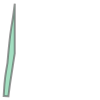

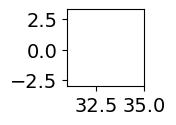

In [189]:
fig = plt.figure(figsize=(1,1))
ax = fig.add_subplot(1, 1, 1)
ti = np.linspace(-3,3.3,ydim)
si = np.linspace(31,35,xdim)

# find the lcdw values
cs = ax.contourf(si, ti, dens_neut, levels=[28.27,28.75],colors="black", zorder=1,alpha=0,linestyles='-.')
p = cs.collections[0].get_paths()[0]
v = p.vertices
ft = Freez_temp
si2 = si.copy()
si2 = np.append(si2,[max(si2),min(si2),min(si2)])
ft = np.append(ft,[3.5,3.5,max(ft)])
b = np.array([[a,b] for a,b in zip(si2,ft)])
a = sg.Polygon(v)
b = sg.Polygon(b)
lcdw = a.intersection(b)
lcdw

tmin, tmax, smin, smax sizes=, -3.3 3.63 30.69 35.35


NameError: name 'dens_neut' is not defined

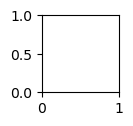

In [17]:
# add the polygons and the points
smin = 31 - (0.01 * 31)    #salt_ctrl_subregR.min - (0.01 * salt_ctrl_subregR.min)
smax = 35. + (0.01 * 35.)    #salt_ctrl_subregR.max + (0.01 * salt_ctrl_subregR.max)
tmin = -3 + (0.1 * -3)       #temp_ctrl_subregR.min - (0.1 * temp_ctrl_subregR.max)
tmax = 3.3 + (0.1 * 3.3)       #temp_ctrl_subregR.max + (0.1 * temp_ctrl_subregR.max)
print('tmin, tmax, smin, smax sizes=,', tmin, tmax, smin, smax)
# Calculate how many gridcells we need in the x and y dimensions
xdim = 20
ydim = 20
# Create empty grid of zeros
dens = np.zeros((ydim,xdim))
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(-3,3.3,ydim)
si = np.linspace(31,35,xdim)
Freez_temp = gsw.CT_freezing(si,0,0)

# convert to practical/potential
ti = gsw.pt_from_CT(si,ti)
si = gsw.SP_from_SA(si,0,long,lat)

Si, Ti = np.meshgrid(si, ti, sparse=False, indexing='ij')
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        #print(si[i],ti[j])
        dens[j,i]=gsw.rho(si[i],ti[j],0)
        # Substract 1000 to convert to sigma-0
dens = dens - 1000


# create the polygons for the next plot
fig = plt.figure(figsize=(1,1))
ax = fig.add_subplot(1, 1, 1)

# add aabw values
cs = ax.contourf(si, ti, dens_neut, levels=[28.27,31],colors="black", zorder=1,alpha=0,linestyles='-.')
cl=plt.clabel(cs,fontsize=10,inline=False,fmt="%.2f")
# get the density vertices
p = cs.collections[0].get_paths()[0]
v = p.vertices
# get the TS vertices
s = np.array([34.5,34.75,34.75,34.5,34.5])
t = np.array([-3,-3,0.1,0.1,-3])
b = np.array([[a,b] for a,b in zip(s,t)])
# # find intersection and plot
a = sg.Polygon(v)
#b = sg.Polygon(b)
ft = Freez_temp
si2 = si.copy()
si2 = np.append(si2,[max(si2),min(si2),min(si2)])
ft = np.append(ft,[0.1,0.1,max(ft)])
c = np.array([[a,b] for a,b in zip(si2,ft)])
c = sg.Polygon(c)
#d = a.intersection(b)
aabw = c.intersection(a)

# find the mcdw values
cs = ax.contourf(si, ti, dens_neut, levels=[28,28.7],colors="black", zorder=1,alpha=0,linestyles='-.')
p = cs.collections[0].get_paths()[0]
v = p.vertices
ft = Freez_temp
si2 = si.copy()
si2 = np.append(si2,[max(si2),min(si2),min(si2)])
ft = np.append(ft,[1.5,1.5,max(ft)])
b = np.array([[a,b] for a,b in zip(si2,ft)])
a = sg.Polygon(v)
b = sg.Polygon(b)
mcdw = a.intersection(b)

# find the lcdw values
cs = ax.contourf(si, ti, dens, levels=[27.7,27.9],colors="black", zorder=1,alpha=0,linestyles='-.')
p = cs.collections[0].get_paths()[0]
v = p.vertices
ft = Freez_temp
si2 = si.copy()
si2 = np.append(si2,[max(si2),min(si2),min(si2)])
ft = np.append(ft,[3.5,3.5,max(ft)])
b = np.array([[a,b] for a,b in zip(si2,ft)])
a = sg.Polygon(v)
b = sg.Polygon(b)
lcdw = a.intersection(b)

# find the dsw values
cs = ax.contourf(si, ti, dens_neut, levels=[28.27,31],colors="black", zorder=1,alpha=0,linestyles='-.')
p = cs.collections[0].get_paths()[0]
v = p.vertices
a = sg.Polygon(v)
ftmax = Freez_temp+0.1
ftmin = Freez_temp-0.5
ft = np.append(ftmax,np.flip(ftmin))
si2 = si.copy()
si2 = np.append(si2,np.flip(si2))
b = np.array([[a,b] for a,b in zip(si2,ft)])
b = sg.Polygon(b)          # second shape in temperature
sx = np.array([34.5,34.5,36,36])
sy = np.array([-3,3.5,3.5,-3])
ss = np.array([[a,b] for a,b in zip(sx,sy)])
c = sg.Polygon(ss)             # third shape in salinity
dsw = b.intersection(c)

# find the aasw values
cs = ax.contourf(si, ti, dens_neut, levels=[24,28],colors="black", zorder=1,alpha=0,linestyles='-.')
p = cs.collections[0].get_paths()[0]
v = p.vertices
a = sg.Polygon(v)              # first shape in density
sx = np.array([34.5,34.5,31,31])
sy = np.array([-3,3.5,3.5,-3])
ss = np.array([[a,b] for a,b in zip(sx,sy)])
b = sg.Polygon(ss)             # second shape in salinity
ft = Freez_temp
ft = np.append(ft,[3.5,3.5])
si2 = si.copy()
si2 = np.append(si2,[35,31])
ta = np.array([[a,b] for a,b in zip(si2,ft)])
c = sg.Polygon(ta)              # third shape in temperature
d = b.intersection(c)
aasw = d.intersection(a)

# find the msw values
#cs = ax.contourf(si, ti, dens_neut, levels=[28,31],colors="black", zorder=1,alpha=0,linestyles='-.')
#Freez_temp = gsw.CT_freezing(si,0,0)
#p = cs.collections[0].get_paths()[0]
#v = p.vertices                 # first shape in density
#a = sg.Polygon(v)
sx = np.array([34.5,34.5,36,36])
sy = np.array([-3,3.5,3.5,-3])
ss = np.array([[a,b] for a,b in zip(sx,sy)])
b = sg.Polygon(ss)             # second shape in salinity
ft = Freez_temp + 0.1
ft = ft[ft<=-1.55]
ft = np.append(ft,[-1.55,-1.55])
si2 = si.copy()
si2 = np.append(si2,[35,31])
ta = np.array([[a,b] for a,b in zip(si2,ft)])
c = sg.Polygon(ta)              # third shape in temperature
#d = a.intersection(b)
msw = b.intersection(c)

# add ISW values
ft = Freez_temp# - 0.05
si2 = si.copy()
si2 = np.append(si2,[max(si2),min(si2),min(si2)])
ft = np.append(ft,[-3,-3,max(ft)])
b = np.array([[a,b] for a,b in zip(si2,ft)])
isw = sg.Polygon(b)
isw = isw.difference(dsw)
isw = isw.difference(aabw)

tmin, tmax, smin, smax sizes=, -3.3 3.63 30.69 35.35


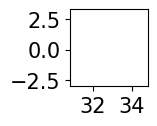

In [37]:
# add the polygons and the points
smin = 31 - (0.01 * 31)    #salt_ctrl_subregR.min - (0.01 * salt_ctrl_subregR.min)
smax = 35. + (0.01 * 35.)    #salt_ctrl_subregR.max + (0.01 * salt_ctrl_subregR.max)
tmin = -3 + (0.1 * -3)       #temp_ctrl_subregR.min - (0.1 * temp_ctrl_subregR.max)
tmax = 3.3 + (0.1 * 3.3)       #temp_ctrl_subregR.max + (0.1 * temp_ctrl_subregR.max)
print('tmin, tmax, smin, smax sizes=,', tmin, tmax, smin, smax)
# Calculate how many gridcells we need in the x and y dimensions
xdim = 20
ydim = 20
# Create empty grid of zeros
dens = np.zeros((ydim,xdim))
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(-3,3.3,ydim)
si = np.linspace(31,35,xdim)
Freez_temp = gsw.CT_freezing(si,0,0)

# convert to practical/potential
ti = gsw.pt_from_CT(si,ti)
si = gsw.SP_from_SA(si,0,long,lat)

Si, Ti = np.meshgrid(si, ti, sparse=False, indexing='ij')
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        #print(si[i],ti[j])
        dens[j,i]=gsw.rho(si[i],ti[j],0)
        # Substract 1000 to convert to sigma-0
dens = dens - 1000


# create the polygons for the next plot
fig = plt.figure(figsize=(1,1))
ax = fig.add_subplot(1, 1, 1)

# add aabw values
cs = ax.contourf(si, ti, dens, levels=[27.68,31],colors="black", zorder=1,alpha=0,linestyles='-.')
cl=plt.clabel(cs,fontsize=10,inline=False,fmt="%.2f")
# get the density vertices
p = cs.collections[0].get_paths()[0]
v = p.vertices
# get the TS vertices
s = np.array([34.5,36,36,34.5,34.5])
t = np.array([-3,-3,0.1,0.1,-3])
b = np.array([[a,b] for a,b in zip(s,t)])
# # find intersection and plot
a = sg.Polygon(v)
b = sg.Polygon(b)
ft = Freez_temp
si2 = si.copy()
si2 = np.append(si2,[max(si2),min(si2),min(si2)])
ft = np.append(ft,[0.1,0.1,max(ft)])
c = np.array([[a,b] for a,b in zip(si2,ft)])
c = sg.Polygon(c)
d = a.intersection(b)
aabw = c.intersection(d)
ft = Freez_temp[-2:]
si2 = si[-2:].copy()
si2 = np.append(si2,[max(si2),min(si2),min(si2)])
ft = np.append(ft,[-1,-1,max(ft)])
b = np.array([[a,b] for a,b in zip(si2,ft)])
b = sg.Polygon(b)
aabw = aabw.union(b)

# find the winter water values
cs = ax.contourf(si, ti, dens, levels=[27.4,27.6],colors="black", zorder=1,alpha=0,linestyles='-.')
p = cs.collections[0].get_paths()[0]
v = p.vertices
ft = Freez_temp
si2 = si.copy()
si2 = np.append(si2,[max(si2),min(si2),min(si2)])
ft = np.append(ft,[-1.5,-1.5,max(ft)])
b = np.array([[a,b] for a,b in zip(si2,ft)])
a = sg.Polygon(v)
b = sg.Polygon(b)
ww = a.intersection(b)

# find the UCDW values
cs = ax.contourf(si, ti, dens, levels=[27.6,27.68],colors="black", zorder=1,alpha=0,linestyles='-.')
p = cs.collections[0].get_paths()[0]
v = p.vertices
a = sg.Polygon(v)
# get the TS vertices
s = np.array([34,36,36,34,34])
t = np.array([-0.5,-0.5,3.5,3.5,-0.5])
b = np.array([[a,b] for a,b in zip(s,t)])
b = sg.Polygon(b)
ucdw = a.intersection(b)

# find the mcdw values
cs = ax.contourf(si, ti, dens, levels=[27.6,27.68],colors="black", zorder=1,alpha=0,linestyles='-.')
p = cs.collections[0].get_paths()[0]
v = p.vertices
ft = Freez_temp
si2 = si.copy()
si2 = np.append(si2,[max(si2),min(si2),min(si2)])
ft = np.append(ft,[1.5,1.5,max(ft)])
b = np.array([[a,b] for a,b in zip(si2,ft)])
a = sg.Polygon(v)
b = sg.Polygon(b)
mcdw = a.intersection(b)

# find the lcdw values
cs = ax.contourf(si, ti, dens, levels=[27.68,27.9],colors="black", zorder=1,alpha=0,linestyles='-.')
p = cs.collections[0].get_paths()[0]
v = p.vertices
#ft = Freez_temp
#si2 = si.copy()
#si2 = np.append(si2,[max(si2),min(si2),min(si2)])
#ft = np.append(ft,[3.5,3.5,max(ft)])
#b = np.array([[a,b] for a,b in zip(si2,ft)])
a = sg.Polygon(v)
#b = sg.Polygon(b)
s = np.array([34.3,35,35,34.3,34.3])
t = np.array([0.1,0.1,3.3,3.3,0.1])
d = np.array([[a,b] for a,b in zip(s,t)])
c = sg.Polygon(d)
e = a.intersection(c)
lcdw = e #.intersection(c)

# find the dsw values
cs = ax.contourf(si, ti, dens, levels=[27.68,31],colors="black", zorder=1,alpha=0,linestyles='-.')
p = cs.collections[0].get_paths()[0]
v = p.vertices
a = sg.Polygon(v)
# ftmax = Freez_temp+0.1
# ftmin = Freez_temp-0.5
# ft = np.append(ftmax,np.flip(ftmin))
# si2 = si.copy()
# si2 = np.append(si2,np.flip(si2))
# b = np.array([[a,b] for a,b in zip(si2,ft)])
sx = np.array([34.8,34.8,31,31])
sy = np.array([-3,-1.7,-1.7,-3])
ss = np.array([[a,b] for a,b in zip(sx,sy)])
b = sg.Polygon(ss)             # second shape in salinity
#dsw = b.intersection(c)
dsw = b.intersection(a)

# # find the msw values
# cs = ax.contourf(si, ti, dens, levels=[27.68,31],colors="black", zorder=1,alpha=0,linestyles='-.')
# p = cs.collections[0].get_paths()[0]
# v = p.vertices
# a = sg.Polygon(v)
# # ftmax = Freez_temp+0.1
# # ftmin = Freez_temp-0.5
# # ft = np.append(ftmax,np.flip(ftmin))
# # si2 = si.copy()
# # si2 = np.append(si2,np.flip(si2))
# # b = np.array([[a,b] for a,b in zip(si2,ft)])
# sx = np.array([34.8,34.8,31,31])
# sy = np.array([-0.4,-1.75,-1.75,-0.4])
# ss = np.array([[a,b] for a,b in zip(sx,sy)])
# b = sg.Polygon(ss)             # second shape in salinity
# #dsw = b.intersection(c)
# msw = b.intersection(a)
# msw = msw.difference(dsw)

# find the aasw values
cs = ax.contourf(si, ti, dens, levels=[24,27.6],colors="black", zorder=1,alpha=0,linestyles='-.')
p = cs.collections[0].get_paths()[0]
v = p.vertices
a = sg.Polygon(v)              # first shape in density
sx = np.array([34.8,34.8,31,31])
sy = np.array([-3,3.5,3.5,-3])
ss = np.array([[a,b] for a,b in zip(sx,sy)])
b = sg.Polygon(ss)             # second shape in salinity
ft = Freez_temp
ft = np.append(ft,[3.5,3.5])
si2 = si.copy()
si2 = np.append(si2,[35,31])
ta = np.array([[a,b] for a,b in zip(si2,ft)])
c = sg.Polygon(ta)              # third shape in temperature
d = b.intersection(c)
aasw = d.intersection(a)

# find the msw values
cs = ax.contourf(si, ti, dens, levels=[27.68,31],colors="black", zorder=1,alpha=0,linestyles='-.')
p = cs.collections[0].get_paths()[0]
v = p.vertices
a = sg.Polygon(v)
ft = Freez_temp + 0.1
ft = np.append(ft,[-0.4,-0.4])
si2 = si.copy()
si2 = np.append(si2,[35,31])
ta = np.array([[a,b] for a,b in zip(si2,ft)])
c = sg.Polygon(ta)              # third shape in temperature
#dsw = b.intersection(c)
msw = c.intersection(a)
msw = msw.difference(dsw)

# add ISW values
cs = ax.contourf(si, ti, dens, levels=[25,27.68],colors="black", zorder=1,alpha=0,linestyles='-.')
p = cs.collections[0].get_paths()[0]
v = p.vertices
a = sg.Polygon(v)
ft = Freez_temp# - 0.05
si2 = si.copy()
si2 = np.append(si2,[max(si2),min(si2),min(si2)])
ft = np.append(ft,[-3,-3,max(ft)])
b = np.array([[a,b] for a,b in zip(si2,ft)])
b = sg.Polygon(b)
isw = b.intersection(a)
#isw = isw.difference(dsw)
isw = isw.difference(aabw)
lcdw = lcdw.difference(dsw)
#lcdw = lcdw.difference(msw)
lcdw = lcdw.difference(mcdw)
ucdw = ucdw.difference(mcdw)
aasw = aasw.difference(ww)
aasw = aasw.difference(ucdw)

# find the aaiw values
cs = ax.contourf(si, ti, dens, levels=[27.2,27.4],colors="black", zorder=1,alpha=0,linestyles='-.')
p = cs.collections[0].get_paths()[0]
v = p.vertices
a = sg.Polygon(v)              # first shape in density
sx = np.array([34.6,34.6,32,32])
sy = np.array([2,3.5,3.5,2])
ss = np.array([[a,b] for a,b in zip(sx,sy)])
b = sg.Polygon(ss)             # second shape in salinity
ft = Freez_temp
ft = np.append(ft,[3.5,3.5])
si2 = si.copy()
si2 = np.append(si2,[35,31])
ta = np.array([[a,b] for a,b in zip(si2,ft)])
c = sg.Polygon(ta)              # third shape in temperature
d = b.intersection(c)
aaiw = d.intersection(a)

## Add the mean pathways for the final 3 months

In [165]:
tests0 = np.mean(salt[:,group0][-17280:],axis=0)
testt0 = np.mean(temp[:,group0][-17280:],axis=0)

tests1 = np.mean(salt[:,group1][-17280:],axis=0)
testt1 = np.mean(temp[:,group1][-17280:],axis=0)

tests2 = np.mean(salt[:,group2][-17280:],axis=0)
testt2 = np.mean(temp[:,group2][-17280:],axis=0)

tests3 = np.mean(salt[:,group3][-17280:],axis=0)
testt3 = np.mean(temp[:,group3][-17280:],axis=0)

tests4 = np.mean(salt[:,group4][-17280:],axis=0)
testt4 = np.mean(temp[:,group4][-17280:],axis=0)

tests5 = np.mean(salt[:,group5][-17280:],axis=0)
testt5 = np.mean(temp[:,group5][-17280:],axis=0)

In [166]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

y = tests0.reshape(len(tests0),1)
xfit0 = testt0.reshape(len(tests0),1)
poly_features = PolynomialFeatures(degree = 5, include_bias = False)
X_poly = poly_features.fit_transform(xfit0)
reg = LinearRegression()
reg.fit(X_poly,y)
X_vals_poly = poly_features.transform(xfit0)
yfit0 = reg.predict(X_vals_poly)

y = tests1.reshape(len(tests1),1)
xfit1 = testt1.reshape(len(tests1),1)
poly_features = PolynomialFeatures(degree = 5, include_bias = False)
X_poly = poly_features.fit_transform(xfit1)
reg = LinearRegression()
reg.fit(X_poly,y)
X_vals_poly = poly_features.transform(xfit1)
yfit1 = reg.predict(X_vals_poly)

y = tests2.reshape(len(tests2),1)
xfit2 = testt2.reshape(len(tests2),1)
poly_features = PolynomialFeatures(degree = 5, include_bias = False)
X_poly = poly_features.fit_transform(xfit2)
reg = LinearRegression()
reg.fit(X_poly,y)
X_vals_poly = poly_features.transform(xfit2)
yfit2 = reg.predict(X_vals_poly)

y = tests3.reshape(len(tests3),1)
xfit3 = testt3.reshape(len(tests3),1)
poly_features = PolynomialFeatures(degree = 5, include_bias = False)
X_poly = poly_features.fit_transform(xfit3)
reg = LinearRegression()
reg.fit(X_poly,y)
X_vals_poly = poly_features.transform(xfit3)
yfit3 = reg.predict(X_vals_poly)

y = tests4.reshape(len(tests4),1)
xfit4 = testt4.reshape(len(tests4),1)
poly_features = PolynomialFeatures(degree = 5, include_bias = False)
X_poly = poly_features.fit_transform(xfit4)
reg = LinearRegression()
reg.fit(X_poly,y)
X_vals_poly = poly_features.transform(xfit4)
yfit4 = reg.predict(X_vals_poly)

y = tests5.reshape(len(tests5),1)
xfit5 = testt5.reshape(len(tests5),1)
poly_features = PolynomialFeatures(degree = 5, include_bias = False)
X_poly = poly_features.fit_transform(xfit5)
reg = LinearRegression()
reg.fit(X_poly,y)
X_vals_poly = poly_features.transform(xfit5)
yfit5 = reg.predict(X_vals_poly)

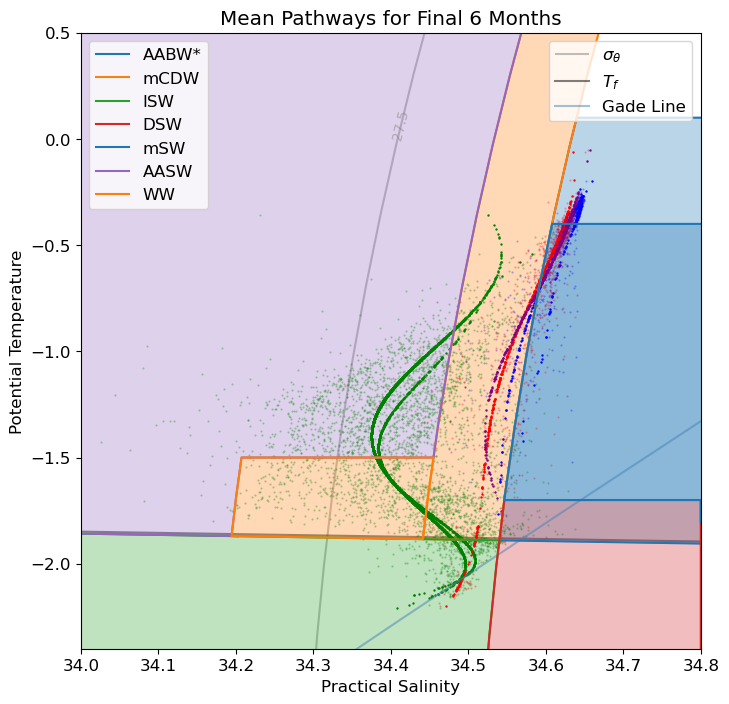

In [179]:
#POLYGONS


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
# plt.ylim(-2.4,max(ti))
# plt.xlim(32,34.8)
plt.ylim(-2.4,0.5)
plt.xlim(34,34.8)
shapes = np.array([])
shapelabels = np.array([])
# plt.plot(salt_flat,temp_flat,'o',markersize=0.1,zorder=0)
plt.rcParams.update({'font.size': 15})


plt.rcParams.update({'font.size': 12})

# add the potential density lines
cs = ax.contour(si, ti, dens, colors="grey", zorder=1,alpha=0.5)
cl=plt.clabel(cs,fontsize=10,inline=False,fmt="%.1f")
h, l = cs.legend_elements()
h = np.array([h[0]],dtype=object)
l = np.array(["$\sigma_{θ}$"])

# add the neutral density lines
# cs = ax.contour(si, ti, dens_neut,colors="black", zorder=1,alpha=0.5,linestyles='-.')
# cl=plt.clabel(cs,fontsize=10,inline=False,fmt="%.1f")
# a,b = cs.legend_elements()
# a = np.array([a[0]],dtype=object)
# b = np.array(["$\gamma$"])
# h = np.append(h,a[0])
# l = np.append(l,b[0])

# add the freezing temperature
Freez_temp = gsw.CT_freezing(np.linspace(31,35,xdim),0,0)
fline = plt.plot(np.linspace(31,35,xdim),Freez_temp,'-',color='black',label="$T_{f}$",alpha=0.5,zorder=1)
gadeline = plt.plot(si,Tgade,'-',color='steelblue',label='Gade Line',alpha=0.5,zorder=2)
h = np.append(h,fline)
l = np.append(l,"$T_{f}$")
h = np.append(h,gadeline)
l = np.append(l,"Gade Line")

# AABW values
x, y = aabw.exterior.xy
aabw2 = plt.plot(x, y,label="AABW",color="tab:blue")
plt.fill(x, y,alpha=0.3,color="tab:blue")
shapes = np.append(shapes,aabw2)
shapelabels = np.append(shapelabels,"AABW*")
# MCDW values
x, y = mcdw.exterior.xy
mcdw2 = plt.plot(x, y,label="mCDW",color="tab:orange")
plt.fill(x, y,alpha=0.3,color="tab:orange")
shapes = np.append(shapes,mcdw2)
shapelabels = np.append(shapelabels,"mCDW")

# # ISW values
x, y = isw.exterior.xy
isw2 = plt.plot(x, y,label="ISW",color="tab:green")
plt.fill(x, y,alpha=0.3,color="tab:green")
shapes = np.append(shapes,isw2)
shapelabels = np.append(shapelabels,"ISW")
# # DSW values
x, y = dsw.exterior.xy
dsw2 = plt.plot(x, y,label="DSW",color="tab:red")
plt.fill(x, y,alpha=0.3,color="tab:red")
shapes = np.append(shapes,dsw2)
shapelabels = np.append(shapelabels,"DSW")

# # MSW values
x, y = msw.exterior.xy
msw2 = plt.plot(x, y,label="mSW")
plt.fill(x, y,alpha=0.3)
shapes = np.append(shapes,msw2)
shapelabels = np.append(shapelabels,"mSW")

# # AASW values
x, y = aasw.exterior.xy
aasw2 = plt.plot(x, y,label="AASW",color="tab:purple")
plt.fill(x, y,alpha=0.3,color="tab:purple")
shapes = np.append(shapes,aasw2)
shapelabels = np.append(shapelabels,"AASW")

# # mSW values
# x, y = msw.exterior.xy
# msw2 = plt.plot(x, y,label="mSW")
# plt.fill(x, y,alpha=0.3,color="tab:brown")
# shapes = np.append(shapes,msw2)
# shapelabels = np.append(shapelabels,"mSW")

# # LCDW values
# x, y = lcdw.exterior.xy
# lcdw2 = plt.plot(x, y,label="LCDW",color="tab:pink")
# plt.fill(x, y,alpha=0.3,color="tab:pink")
# shapes = np.append(shapes,lcdw2)
# shapelabels = np.append(shapelabels,"LCDW")

# # UCDW values
# x, y = ucdw.exterior.xy
# ucdw2 = plt.plot(x, y,label="UCDW")
# plt.fill(x, y,alpha=0.3)
# shapes = np.append(shapes,ucdw2)
# shapelabels = np.append(shapelabels,"UCDW")

# # WW values
x, y = ww.exterior.xy
ww2 = plt.plot(x, y,label="WW")
plt.fill(x, y,alpha=0.3)
shapes = np.append(shapes,ww2)
shapelabels = np.append(shapelabels,"WW")

# # LCDW values
# x, y = aaiw.exterior.xy
# aaiw2 = plt.plot(x, y,label="AAIW")
# plt.fill(x, y,alpha=0.3,color="tab:pink")
# shapes = np.append(shapes,aaiw2)
# shapelabels = np.append(shapelabels,"AAIW")

# labels and plot
legend1 = plt.legend(h,l, loc=1)
plt.gca().add_artist(legend1)
plt.legend(shapes,shapelabels, loc="best")

# plt.title("Neutral and potential density of water masses")
plt.title("Mean Pathways for Final 6 Months")
plt.xlabel('Practical Salinity')
plt.ylabel('Potential Temperature')

plt.scatter(tests0,testt0,s=0.3,marker='o',color="green",label="Group 1",alpha=0.3)
plt.scatter(yfit0,xfit0,s=0.5,marker='o',color="green",label="Group 1")
plt.scatter(tests1,testt1,s=0.3,marker='o',color="green",label="Group 2",alpha=0.3)
plt.scatter(yfit1,xfit1,s=0.5,marker='o',color="green",label="Group 2")
plt.scatter(tests2,testt2,s=0.3,marker='o',color="blue",label="Group 3",alpha=0.3)
plt.scatter(yfit2,xfit2,s=0.5,marker='o',color="blue",label="Group 3")
plt.scatter(tests3,testt3,s=0.3,marker='o',color="blue",label="Group 4",alpha=0.3)
plt.scatter(yfit3,xfit3,s=0.5,marker='o',color="blue",label="Group 4")
plt.scatter(tests4,testt4,s=0.3,marker='o',color="red",label="Group 5",alpha=0.3)
plt.scatter(yfit4,xfit4,s=0.5,marker='o',color="red",label="Group 5")
plt.scatter(tests5,testt5,s=0.3,marker='o',color="purple",label="Group 6",alpha=0.3)
plt.scatter(yfit5,xfit5,s=0.5,marker='o',color="purple",label="Group 6")

plt.savefig("/scratch/project_2000789/muramarg/KMeans/FINAL/mean_pathways.png", dpi=300)
plt.show()

In [114]:
saltflat = salt[:,test][-8640:].flatten()
tempflat = temp[:,test][-8640:].flatten()

In [175]:
T_wdw = -2.05
S_wdw = 34.5
Lf = 334 # kJ/kg
Cp = gsw.cp_t_exact(S_wdw,T_wdw,0)/1000
print(Cp)

Tgade = T_wdw + (Lf/Cp)*(1 - (S_wdw/si))

3.9907110140574806


## Make the polygons

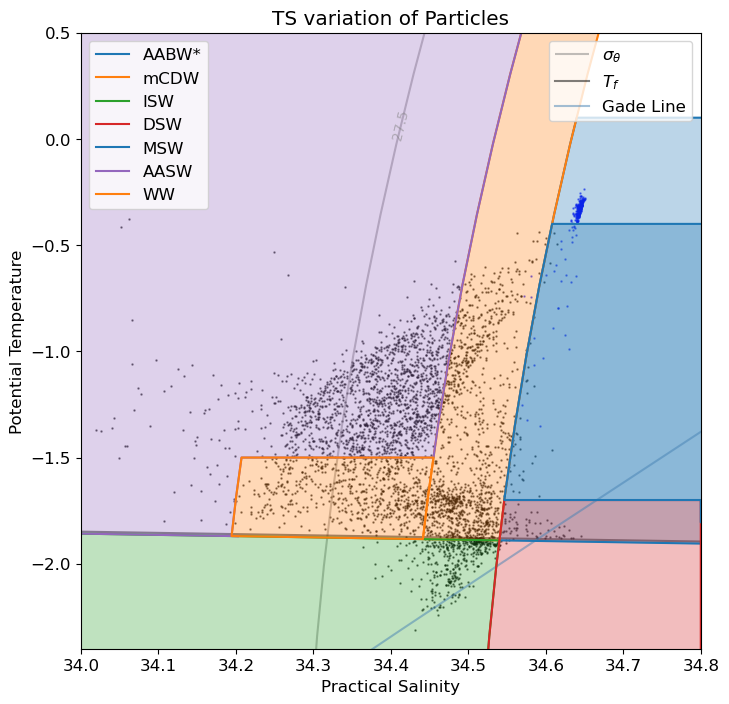

In [81]:
#POLYGONS


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
# plt.ylim(-2.4,max(ti))
# plt.xlim(32,34.8)
plt.ylim(-2.4,0.5)
plt.xlim(34,34.8)
shapes = np.array([])
shapelabels = np.array([])
# plt.plot(salt_flat,temp_flat,'o',markersize=0.1,zorder=0)
plt.rcParams.update({'font.size': 15})


plt.rcParams.update({'font.size': 12})

# add the potential density lines
cs = ax.contour(si, ti, dens, colors="grey", zorder=1,alpha=0.5)
cl=plt.clabel(cs,fontsize=10,inline=False,fmt="%.1f")
h, l = cs.legend_elements()
h = np.array([h[0]],dtype=object)
l = np.array(["$\sigma_{θ}$"])

# add the neutral density lines
# cs = ax.contour(si, ti, dens_neut,colors="black", zorder=1,alpha=0.5,linestyles='-.')
# cl=plt.clabel(cs,fontsize=10,inline=False,fmt="%.1f")
# a,b = cs.legend_elements()
# a = np.array([a[0]],dtype=object)
# b = np.array(["$\gamma$"])
# h = np.append(h,a[0])
# l = np.append(l,b[0])

# add the freezing temperature
Freez_temp = gsw.CT_freezing(np.linspace(31,35,xdim),0,0)
fline = plt.plot(np.linspace(31,35,xdim),Freez_temp,'-',color='black',label="$T_{f}$",alpha=0.5,zorder=1)
gadeline = plt.plot(si,Tgade,'-',color='steelblue',label='Gade Line',alpha=0.5,zorder=2)
h = np.append(h,fline)
l = np.append(l,"$T_{f}$")
h = np.append(h,gadeline)
l = np.append(l,"Gade Line")

# AABW values
x, y = aabw.exterior.xy
aabw2 = plt.plot(x, y,label="AABW",color="tab:blue")
plt.fill(x, y,alpha=0.3,color="tab:blue")
shapes = np.append(shapes,aabw2)
shapelabels = np.append(shapelabels,"AABW*")
# MCDW values
x, y = mcdw.exterior.xy
mcdw2 = plt.plot(x, y,label="mCDW",color="tab:orange")
plt.fill(x, y,alpha=0.3,color="tab:orange")
shapes = np.append(shapes,mcdw2)
shapelabels = np.append(shapelabels,"mCDW")

# # ISW values
x, y = isw.exterior.xy
isw2 = plt.plot(x, y,label="ISW",color="tab:green")
plt.fill(x, y,alpha=0.3,color="tab:green")
shapes = np.append(shapes,isw2)
shapelabels = np.append(shapelabels,"ISW")
# # DSW values
x, y = dsw.exterior.xy
dsw2 = plt.plot(x, y,label="DSW",color="tab:red")
plt.fill(x, y,alpha=0.3,color="tab:red")
shapes = np.append(shapes,dsw2)
shapelabels = np.append(shapelabels,"DSW")

# # MSW values
x, y = msw.exterior.xy
msw2 = plt.plot(x, y,label="MSW")
plt.fill(x, y,alpha=0.3)
shapes = np.append(shapes,msw2)
shapelabels = np.append(shapelabels,"MSW")

# # AASW values
x, y = aasw.exterior.xy
aasw2 = plt.plot(x, y,label="AASW",color="tab:purple")
plt.fill(x, y,alpha=0.3,color="tab:purple")
shapes = np.append(shapes,aasw2)
shapelabels = np.append(shapelabels,"AASW")

# # mSW values
# x, y = msw.exterior.xy
# msw2 = plt.plot(x, y,label="mSW")
# plt.fill(x, y,alpha=0.3,color="tab:brown")
# shapes = np.append(shapes,msw2)
# shapelabels = np.append(shapelabels,"mSW")

# # LCDW values
# x, y = lcdw.exterior.xy
# lcdw2 = plt.plot(x, y,label="LCDW",color="tab:pink")
# plt.fill(x, y,alpha=0.3,color="tab:pink")
# shapes = np.append(shapes,lcdw2)
# shapelabels = np.append(shapelabels,"LCDW")

# # UCDW values
# x, y = ucdw.exterior.xy
# ucdw2 = plt.plot(x, y,label="UCDW")
# plt.fill(x, y,alpha=0.3)
# shapes = np.append(shapes,ucdw2)
# shapelabels = np.append(shapelabels,"UCDW")

# # WW values
x, y = ww.exterior.xy
ww2 = plt.plot(x, y,label="WW")
plt.fill(x, y,alpha=0.3)
shapes = np.append(shapes,ww2)
shapelabels = np.append(shapelabels,"WW")

# # LCDW values
# x, y = aaiw.exterior.xy
# aaiw2 = plt.plot(x, y,label="AAIW")
# plt.fill(x, y,alpha=0.3,color="tab:pink")
# shapes = np.append(shapes,aaiw2)
# shapelabels = np.append(shapelabels,"AAIW")

# labels and plot
legend1 = plt.legend(h,l, loc=1)
plt.gca().add_artist(legend1)
plt.legend(shapes,shapelabels, loc="best")

# plt.title("Neutral and potential density of water masses")
plt.title("TS variation of Particles")
plt.xlabel('Practical Salinity')
plt.ylabel('Potential Temperature')
# plt.legend(loc="best")
#plt.annotate('*: Definition in depth not shown', xy=(31.1, -2.1))
#plt.plot(34.6,-0.6,'o',markersize=2)
#plt.plot(34.6,1,'o',markersize=2)
plt.plot(tests0,testt0,'o',markersize=0.8,zorder=0,color="black",alpha=0.5)
plt.plot(tests1,testt1,'o',markersize=0.8,zorder=0,color="black",alpha=0.5)
plt.plot(tests2,testt2,'o',markersize=0.8,zorder=0,color="blue",alpha=0.5)

#plt.plot(saltflat1,tempflat1,'o',markersize=1,zorder=0,color="red",alpha=0.5)
#plt.plot(saltflat2,tempflat2,'o',markersize=0.1,zorder=10,color="red",alpha=0.5)
#plt.savefig("/scratch/project_2000789/muramarg/KMeans/FINAL/group0_avg.png", dpi=300)
plt.show()

## Categorize the points

In [24]:
from shapely.geometry import Point

In [25]:
# coding 0 AABW, 1 MCDW, 2 ISW, 3 DSW, 4 AASW, 5 other, 6 is CDW, 8 is mSW
# use potential T and practical S, 
def wmt_categorize2(temp,Freez_temp,salt,depth,dens,aabw,mcdw,isw,dsw,aasw,ww,msw):
#     print(temp.shape,Freez_temp.shape,salt.shape,enddens_allvals.shape,depth.shape,dens.shape)
    mass = np.array([],dtype=int)
    highd = 0
    lowd = 0
    for t,tf,s,d,rho in zip(temp,Freez_temp,salt,depth,dens):
        point = Point(s,t)
        
        # aabw
        if d<-1000 and aabw.contains(point):
            mass = np.append(mass,0)
        elif d>-1000 and msw.contains(point):
            mass = np.append(mass,6)
            
        # mcdw
        elif mcdw.contains(point): # or aabw.contains(point):                             # modified tf
            mass = np.append(mass,1)

        # dsw
        elif s>=34.5 and t>=(tf-0.5) and t<=(tf+0.1) and rho>=27.68:
            mass = np.append(mass,3)
            
            
        # isw (also defined in yoon)
        elif t<(tf):                                                    # modified tf
            mass = np.append(mass,2)
        # other water masses defined from portela
        # aasw
        elif aasw.contains(point):                                          # modified s
            mass = np.append(mass,4)
        # ww
        elif ww.contains(point):
            mass = np.append(mass,5)
        
        # other shelf waters
        elif aabw.contains(point):
            mass = np.append(mass,6)
        
        else:
            mass = np.append(mass,6)
        
    return(mass)

mass2 = wmt_categorize2(temp[20000],gsw.CT_freezing(SA[20000],0,0),salt[20000],depth[20000],dens[20000],aabw,mcdw,isw,dsw,aasw,ww,msw)
unique_elements, counts_elements = np.unique(mass2, return_counts=True)
print(unique_elements,counts_elements)
print(sum(counts_elements))

unique_elements, counts_elements = np.unique(wmt[20000], return_counts=True)
print(unique_elements,counts_elements)
print(sum(counts_elements))

IndexError: index 20000 is out of bounds for axis 0 with size 20

In [68]:
# # # code an entire array of values of the water mass type the same shape as ds.variables['x'].shape (65717,5460)
#wm_arr = np.empty((35040,5460))
start_time = time.time()

wmt = np.zeros(((35040,5460)))

for i in range(35040): 
#for i in range(5):
    if i%3000 == 0:
        print(i,"/",35040,"in",(time.time()-start_time)/60)
    # get the array values
    thistemp = CT[i]
    thissalt = SA[i]
    thisdepth = depth[i]
    thisdens = dens[i]
    #thisgamma = gamma_n[i]

    SA_salt = SA0[i]
    # get the neutral density values
    #end_dens = pot_to_neut(thissalt,thistemp)
    # characterize each value in the array
    Freez_temp = gsw.CT_freezing(SA_salt,0,0)
    
    wm_mass = wmt_categorize2(thistemp,Freez_temp,thissalt,thisdepth,thisdens,aabw,mcdw,isw,dsw,aasw,ww,msw)
    wmt[i] = wm_mass
wmt.tofile("/scratch/project_2000789/muramarg/KMeans/text_files/wmt4.txt",sep=",")

0 / 35040 in 3.564357757568359e-06
3000 / 35040 in 12.0621742049853
6000 / 35040 in 23.825473276774087
9000 / 35040 in 35.1366094549497
12000 / 35040 in 46.05535517136256
15000 / 35040 in 57.00782789389292
18000 / 35040 in 69.13648176987967
21000 / 35040 in 81.10725568532943
24000 / 35040 in 92.69507697423299
27000 / 35040 in 104.24382715622583
30000 / 35040 in 115.73303601344426
33000 / 35040 in 127.1368147611618


In [4]:
wmt = np.fromfile("/scratch/project_2000789/muramarg/KMeans/text_files/wmt4.txt",sep=",")
wmt = wmt.reshape((35040,5460))

In [13]:
unique_elements, counts_elements = np.unique(wmt[0].flatten(), return_counts=True)
print(unique_elements)
print(counts_elements/5460)

unique_elements, counts_elements = np.unique(wmt[-1].flatten(), return_counts=True)
print(unique_elements)
print(counts_elements/5460)

[1. 2. 3. 4. 5. 6.]
[0.23754579 0.00054945 0.26336996 0.2532967  0.01208791 0.23315018]
[0. 1. 2. 3. 4. 5. 6.]
[0.24450549 0.40750916 0.11666667 0.06355311 0.03608059 0.02161172
 0.11007326]


In [9]:
wmt[wm_arr == 2] = 2

In [10]:
wmt[wm_arr == 1] = 1

In [32]:
wmt

array([[1., 1., 4., ..., 1., 1., 1.],
       [1., 1., 4., ..., 1., 1., 1.],
       [1., 1., 4., ..., 1., 1., 1.],
       ...,
       [3., 6., 6., ..., 1., 1., 1.],
       [3., 6., 6., ..., 1., 1., 1.],
       [3., 6., 6., ..., 1., 1., 1.]])

## Now create the grouping

In [72]:
# convert the absolute salinity from practical salinity
dSA = SA[-1]-SA[0]

# convert potential T to conservative T
dCT = CT[-1]-CT[0]

# find the potential density from SA, CT, p
drho_pot = rho_pot[-1]-rho_pot[0]

df = pd.DataFrame()
df["dT"] = dCT
df["dsat"] = dSA
df["drho"] = drho_pot
df

,dT,dsat,drho
0,-1.425433,0.133150,2.821945
1,-2.106821,0.125954,2.448792
2,-3.121837,0.213226,1.166384
3,-4.459546,0.343017,3.499847
4,-2.252210,0.153492,1.335186
...,...,...,...
5455,0.339512,-0.163499,0.576791
5456,0.277899,0.008086,1.062114
5457,0.082146,-0.061708,0.573581
5458,-0.425667,0.016977,0.554006


[   9 3381 2508  895 3045 1849]
Cluster 0:
947
Cluster 1:
2934
Cluster 2:
282
Cluster 3:
262
Cluster 4:
567
Cluster 5:
468


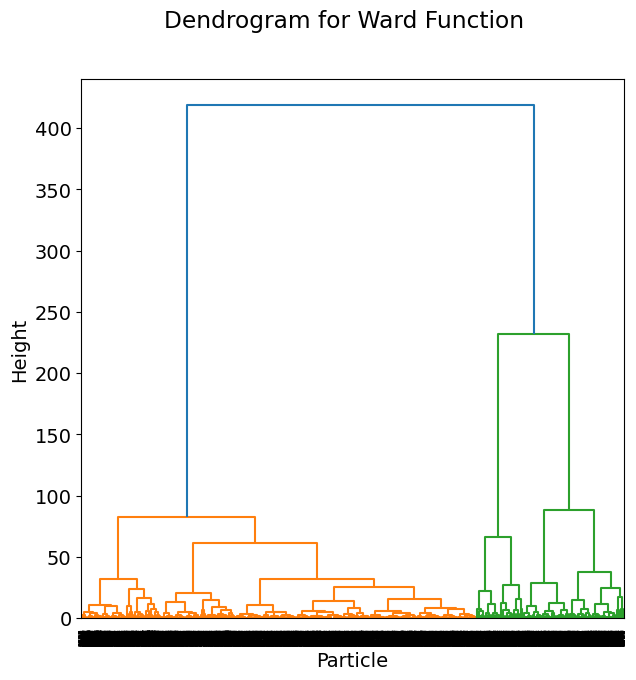

In [73]:
# Plot the dendrogram for the Ward proximity measure
index_names = list(df.index)
z = linkage(df,method='ward')
plt.figure(figsize = (7,7))
plt.suptitle('Dendrogram for Ward Function')
plt.xlabel('Particle')
plt.ylabel('Height')
dendrogramward = dendrogram(Z=z,labels=index_names,get_leaves=True)
# plt.show()

# set the number of clusters and get the names
numclust = 6
fl = fcluster(z,numclust,criterion='maxclust')
# new dataframe
df_clst = pd.DataFrame()
df_clst['index']  = index_names
df_clst['clust_label']  = fl
# get the clusters from fcluster to choose centroids
centroids_idx = np.array([],dtype=int)
for i in range(6):
    # print the values in each group
    elements = df_clst[df_clst['clust_label']==i+1]['index'].tolist()  
    size = len(elements)    
    # get a random number from elements as a centroid
    centroids_idx = np.append(centroids_idx, random.choice(elements))
print(centroids_idx)

# choose the centroids based on the smallest values from the particles
# we will choose the centroids at random from the 6 groups
# get the initial centroids
index_names = list(df.index)
c0 = df.iloc[index_names.index(centroids_idx[0])]
c1 = df.iloc[index_names.index(centroids_idx[1])]
c2 = df.iloc[index_names.index(centroids_idx[2])]
c3 = df.iloc[index_names.index(centroids_idx[3])]
c4 = df.iloc[index_names.index(centroids_idx[4])]
c5 = df.iloc[index_names.index(centroids_idx[5])]

centroids = np.array([c0,c1,c2,c3,c4,c5]) #c5,c6,c7,c8])

# Compute the k-means clusters and show the listing of the States in each cluster
kmeans = KMeans(n_clusters=6,init=centroids,n_init=1,random_state=23).fit(df)
centroids = kmeans.cluster_centers_
assignment = kmeans.fit_predict(df,centroids)

# get the cluster for each state
zeroes=[x for x,y in enumerate(assignment) if y == 0]
ones=[x for x,y in enumerate(assignment) if y == 1]
twos=[x for x,y in enumerate(assignment) if y == 2]
threes=[x for x,y in enumerate(assignment) if y == 3]
fours=[x for x,y in enumerate(assignment) if y == 4]
fives=[x for x,y in enumerate(assignment) if y == 5]

clusters = [zeroes,ones,twos,threes,fours,fives] #sevens,eights]
states = [[],[],[],[],[],[]] #[],[],[],[]]
num = 0
for clust in clusters:
    # cluster to append to is states[num]
    for idx in clust:
        state = index_names[idx]
        states[num].append(state)
    print('Cluster '+str(num)+':')
    print(len(states[num]))
    num += 1

In [17]:
# # get the indices for each of the groups
# group0 = states[0]
# group1 = states[1]
# group2 = states[2]
# group3 = states[3]
# group4 = states[4]
# group5 = states[5]
groups = np.array([group0,group1,group2,group3,group4,group5],dtype=object)

In [22]:
# quality of the grouping
# find the number of values in each group that match each of the water masses
# we have the arrays temp, freez_temp, salt, enddens_allvals, depth
lengths = np.array([])
AABW_percents = np.array([])
MCDW_percents = np.array([])
ISW_percents = np.array([])
DSW_percents = np.array([])
AASW_percents = np.array([])
WW_percents = np.array([])
other_percents = np.array([])

for group in groups:
    # how many particles are in the group
    lengths = np.append(lengths,len(group))
    
    # get the individual quantities of each group from mass and do value counts
    #thismass = wmt[-1][group]
    thismass = wmt[0][group]
    unique_elements, counts_elements = np.unique(thismass, return_counts=True)
    
    # see if any number is not in list and if not then add 0 to the end of the list
    for i in range(7):
        if not np.any(unique_elements == i):
            # append this number and zero to unique,counts
            unique_elements = np.append(unique_elements,i)
            counts_elements = np.append(counts_elements,0)
            
    # 0 is aabw, 1 is mcdw, 2 is isw, 3 is dsw, 4 is aasw, 5 is other (ISW shallower than 100m), 6 is hssw, 7 is lssw
    
    for i in range(len(unique_elements)):
        if unique_elements[i] == 0:
            AABW_percents =np.append(AABW_percents,counts_elements[i])
        elif unique_elements[i] == 1:
            MCDW_percents =np.append(MCDW_percents,counts_elements[i])
        elif unique_elements[i] == 2:
            ISW_percents =np.append(ISW_percents,counts_elements[i])
        elif unique_elements[i] == 3:
            DSW_percents =np.append(DSW_percents,counts_elements[i])
        elif unique_elements[i] == 4:
            AASW_percents =np.append(AASW_percents,counts_elements[i])
        elif unique_elements[i] == 5:
            WW_percents = np.append(WW_percents,counts_elements[i])
        elif unique_elements[i] == 6:
            other_percents = np.append(other_percents,counts_elements[i])

In [23]:
wmt_df = pd.DataFrame()
wmt_df["# of particles"] = lengths
wmt_df["AABW"] = AABW_percents
wmt_df["MCDW"] = MCDW_percents
wmt_df["ISW"] = ISW_percents
wmt_df["DSW"] = DSW_percents
wmt_df["AASW"] = AASW_percents
wmt_df["WW"] = WW_percents
wmt_df["other"] = other_percents
wmt_df

,# of particles,AABW,MCDW,ISW,DSW,AASW,WW,other
0,947.0,0.0,146.0,0.0,0.0,797.0,0.0,4.0
1,2934.0,0.0,849.0,3.0,898.0,341.0,53.0,790.0
2,282.0,0.0,67.0,0.0,88.0,40.0,2.0,85.0
3,262.0,0.0,48.0,0.0,92.0,43.0,1.0,78.0
4,567.0,0.0,117.0,0.0,202.0,83.0,6.0,159.0
5,468.0,0.0,70.0,0.0,158.0,79.0,4.0,157.0


In [21]:
wmt_df = pd.DataFrame()
wmt_df["# of particles"] = lengths
wmt_df["AABW"] = AABW_percents
wmt_df["MCDW"] = MCDW_percents
wmt_df["ISW"] = ISW_percents
wmt_df["DSW"] = DSW_percents
wmt_df["AASW"] = AASW_percents
wmt_df["WW"] = WW_percents
wmt_df["other"] = other_percents
wmt_df

,# of particles,AABW,MCDW,ISW,DSW,AASW,WW,other
0,947.0,0.0,146.0,0.0,0.0,797.0,0.0,4.0
1,2934.0,0.0,849.0,3.0,898.0,341.0,53.0,790.0
2,282.0,0.0,67.0,0.0,88.0,40.0,2.0,85.0
3,262.0,0.0,48.0,0.0,92.0,43.0,1.0,78.0
4,567.0,0.0,117.0,0.0,202.0,83.0,6.0,159.0
5,468.0,0.0,70.0,0.0,158.0,79.0,4.0,157.0


In [26]:
wmt_df["# of particles"].values

array([ 944., 2940.,  282.,  262.,  566.,  466.])

In [14]:
#group0 = np.asarray(group0)
#group0.tofile("/scratch/project_2000789/muramarg/KMeans/FINAL/group0.txt",sep=",")
group0 = np.fromfile("/scratch/project_2000789/muramarg/KMeans/FINAL/group0.txt",sep=",")

#group1 = np.asarray(group1)
#group1.tofile("/scratch/project_2000789/muramarg/KMeans/FINAL/group1.txt",sep=",")
group1 = np.fromfile("/scratch/project_2000789/muramarg/KMeans/FINAL/group1.txt",sep=",")

#group2 = np.asarray(group2)
#group2.tofile("/scratch/project_2000789/muramarg/KMeans/FINAL/group2.txt",sep=",")
group2 = np.fromfile("/scratch/project_2000789/muramarg/KMeans/FINAL/group2.txt",sep=",")

#group3 = np.asarray(group3)
#group3.tofile("/scratch/project_2000789/muramarg/KMeans/FINAL/group3.txt",sep=",")
group3 = np.fromfile("/scratch/project_2000789/muramarg/KMeans/FINAL/group3.txt",sep=",")

#group4 = np.asarray(group4)
#group4.tofile("/scratch/project_2000789/muramarg/KMeans/FINAL/group4.txt",sep=",")
group4 = np.fromfile("/scratch/project_2000789/muramarg/KMeans/FINAL/group4.txt",sep=",")

#group5 = np.asarray(group5)
#group5.tofile("/scratch/project_2000789/muramarg/KMeans/FINAL/group5.txt",sep=",")
group5 = np.fromfile("/scratch/project_2000789/muramarg/KMeans/FINAL/group5.txt",sep=",")

In [15]:
group0 = group0.tolist()
group0 = [int(x) for x in group0]

group1 = group1.tolist()
group1 = [int(x) for x in group1]

group2 = group2.tolist()
group2 = [int(x) for x in group2]

group3 = group3.tolist()
group3 = [int(x) for x in group3]

group4 = group4.tolist()
group4 = [int(x) for x in group4]

group5 = group5.tolist()
group5 = [int(x) for x in group5]

## Create grouped plots

In [52]:
depth_pres = depth*-0.1

In [19]:
# # write the potential densities to a text file gsw from all_salt and all_temp
# with open("/scratch/project_2000789/muramarg/KMeans/formeeting_2_27/pot_dens2.txt", 'w') as f:
#     start_time = time.time()
#     for j in range(pot_dens.shape[0]):
#         if j%5000 == 0:
#             print(j,"/",pot_dens.shape[0],"in",(time.time()-start_time)/60)
#         thisrow = np.array([])
#         for i in range(pot_dens.shape[1]):
#             rho=gsw.rho(salt[j][i],temp[j][i],depth_pres[j][i])
#             rho -= 1000
#             thisrow = np.append(thisrow,rho)
            
#         thisrow = [str(i) for i in thisrow]
#         f.write(','.join(thisrow))
#         f.write("\n")

0 / 35040 in 1.7484029134114582e-07
5000 / 35040 in 13.729596372445425
10000 / 35040 in 26.804861521720888
15000 / 35040 in 40.37134671211243
20000 / 35040 in 53.52592446009318
25000 / 35040 in 67.36504266262054
30000 / 35040 in 80.52081728378931
35000 / 35040 in 94.52543659607569


In [13]:
# # recalculate the density with atm anomaly of 0
# # read the file and add the potential density values from pot_dens.txt
# with open("/scratch/project_2000789/muramarg/KMeans/formeeting_2_27/pot_dens.txt","r") as g:
#     inp = g.read()
#     inp = inp.replace(',', '\n')
#     inp = inp.splitlines()
# g.close()
# lines = np.reshape(inp,depth.shape)
# pot_dens = lines.astype(float)

In [53]:
# depth v rho colored by time
time = temp.shape[0]
time = np.arange(0,time,1)
x_time0 = np.tile(time,(depth.shape[1],1))
x_time0 = x_time0.T   # this will be our time matrix to color the numbers
x_time0 = x_time0*900/86400

time1 = x_time0.astype(int)

1
2
3
4
5
6


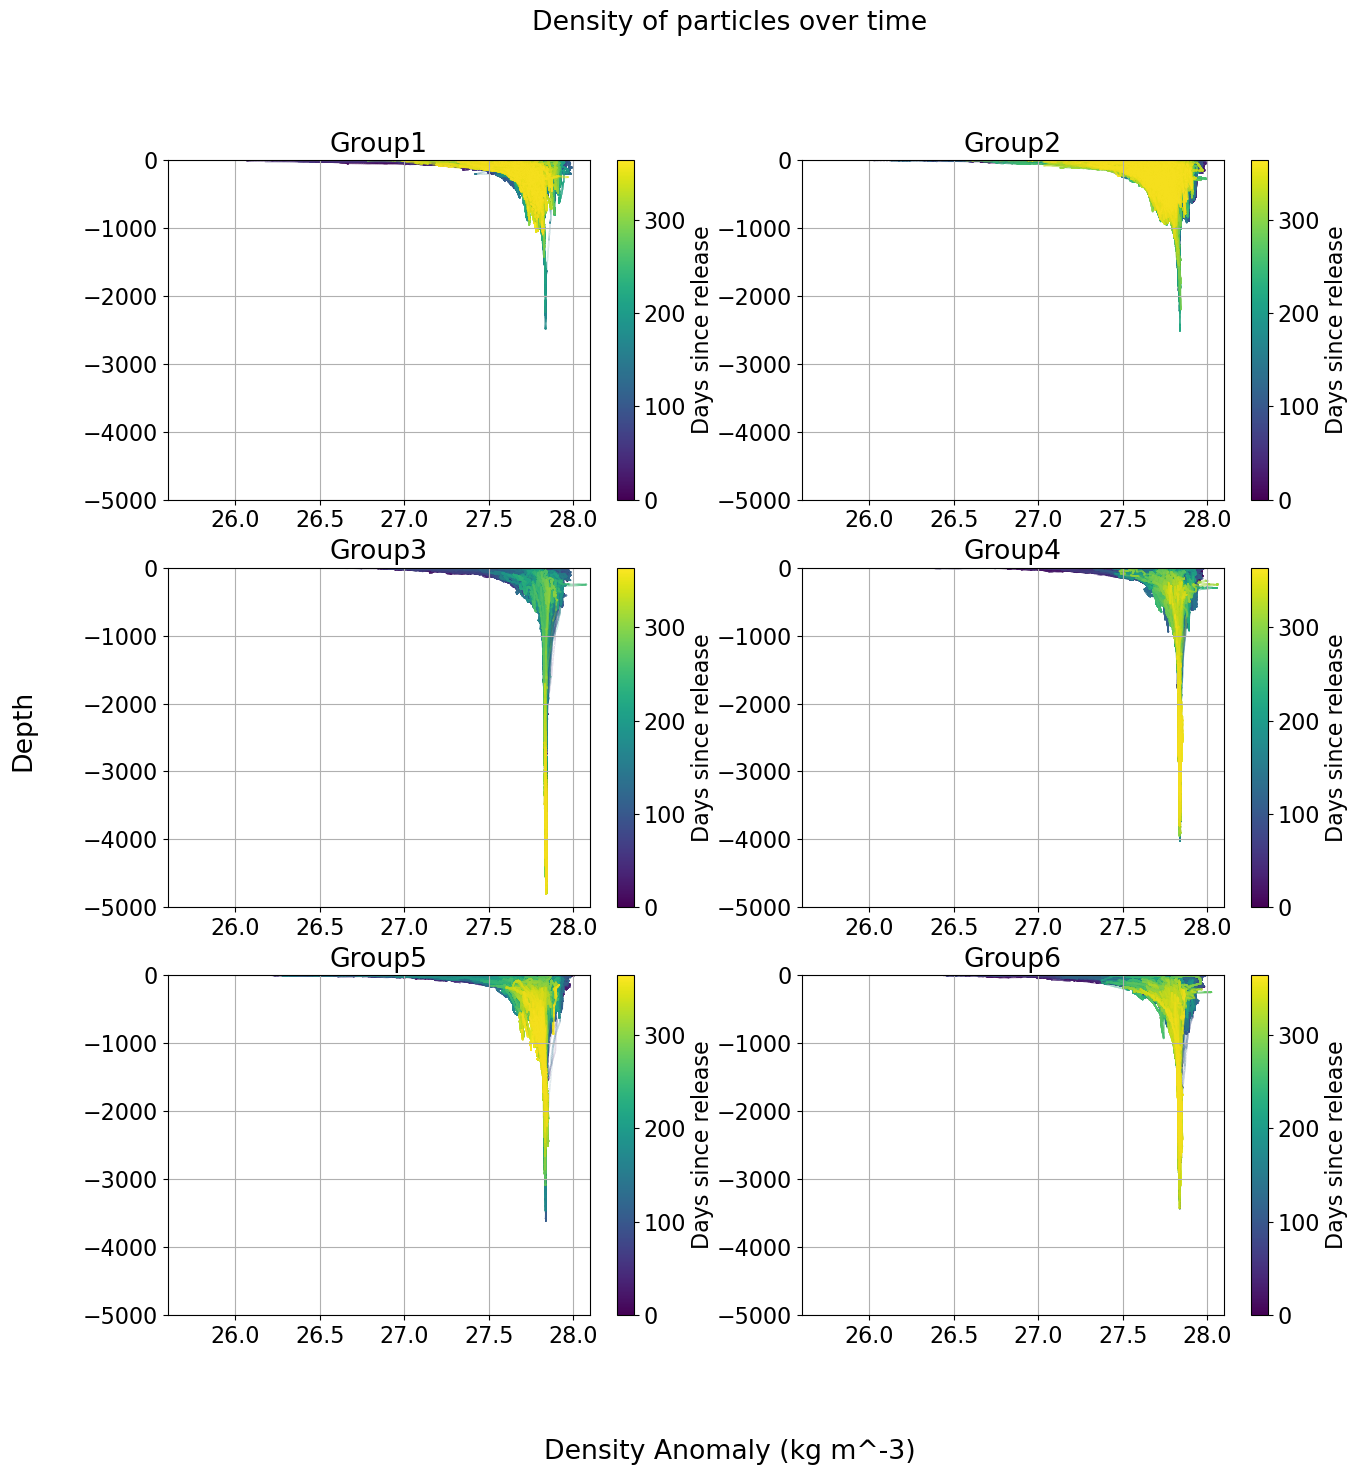

In [60]:
# plot 2 by 3 of density with depth over time of the groupings
fig = plt.figure(figsize=(15,15))
fig.tight_layout(pad=5.0)
i = 1

plt.rcParams.update({'font.size': 16})
fig.suptitle("Density of particles over time")
fig.supxlabel('Density Anomaly (kg m^-3)')
fig.supylabel('Depth')

for group in groups:
    print(i)
    ax = fig.add_subplot(3, 2, i)
    plt.grid()
    plt.xlim(25.6,28.1)
    plt.ylim(-5000, 0)                         # normalize the depth
    plt.scatter(rho_pot0[:,group],depth[:,group],marker=".",s=0.01,c=time1[:,group])
    #plt.scatter(rho_pot[:,group][0],depth[:,group][0],marker="x",c="green",label="Start")
    #plt.scatter(pot_dens[:,group][-1],depth[:,group][-1],marker="x",c="red",label="End")
    #plt.legend(loc="best")
    plt.title("Group"+str(i))
    
    #im2 = ax.imshow(m2, interpolation='None')
    cbar = plt.colorbar(label="Days since release")
    #cbar = plt.colorbar(ticks=[0, 0.2,0.4,0.6,0.8,1],label='Days since release')
    #cbar.set_ticklabels([0,73,146,219,292,365])
    
    i += 1
# plt.show()
plt.savefig("/scratch/project_2000789/muramarg/KMeans/formeeting_328/depthvgamma_new.png", dpi=300)

In [64]:
a = np.sort(rho_pot.flatten())

1
2
3
4
5
6


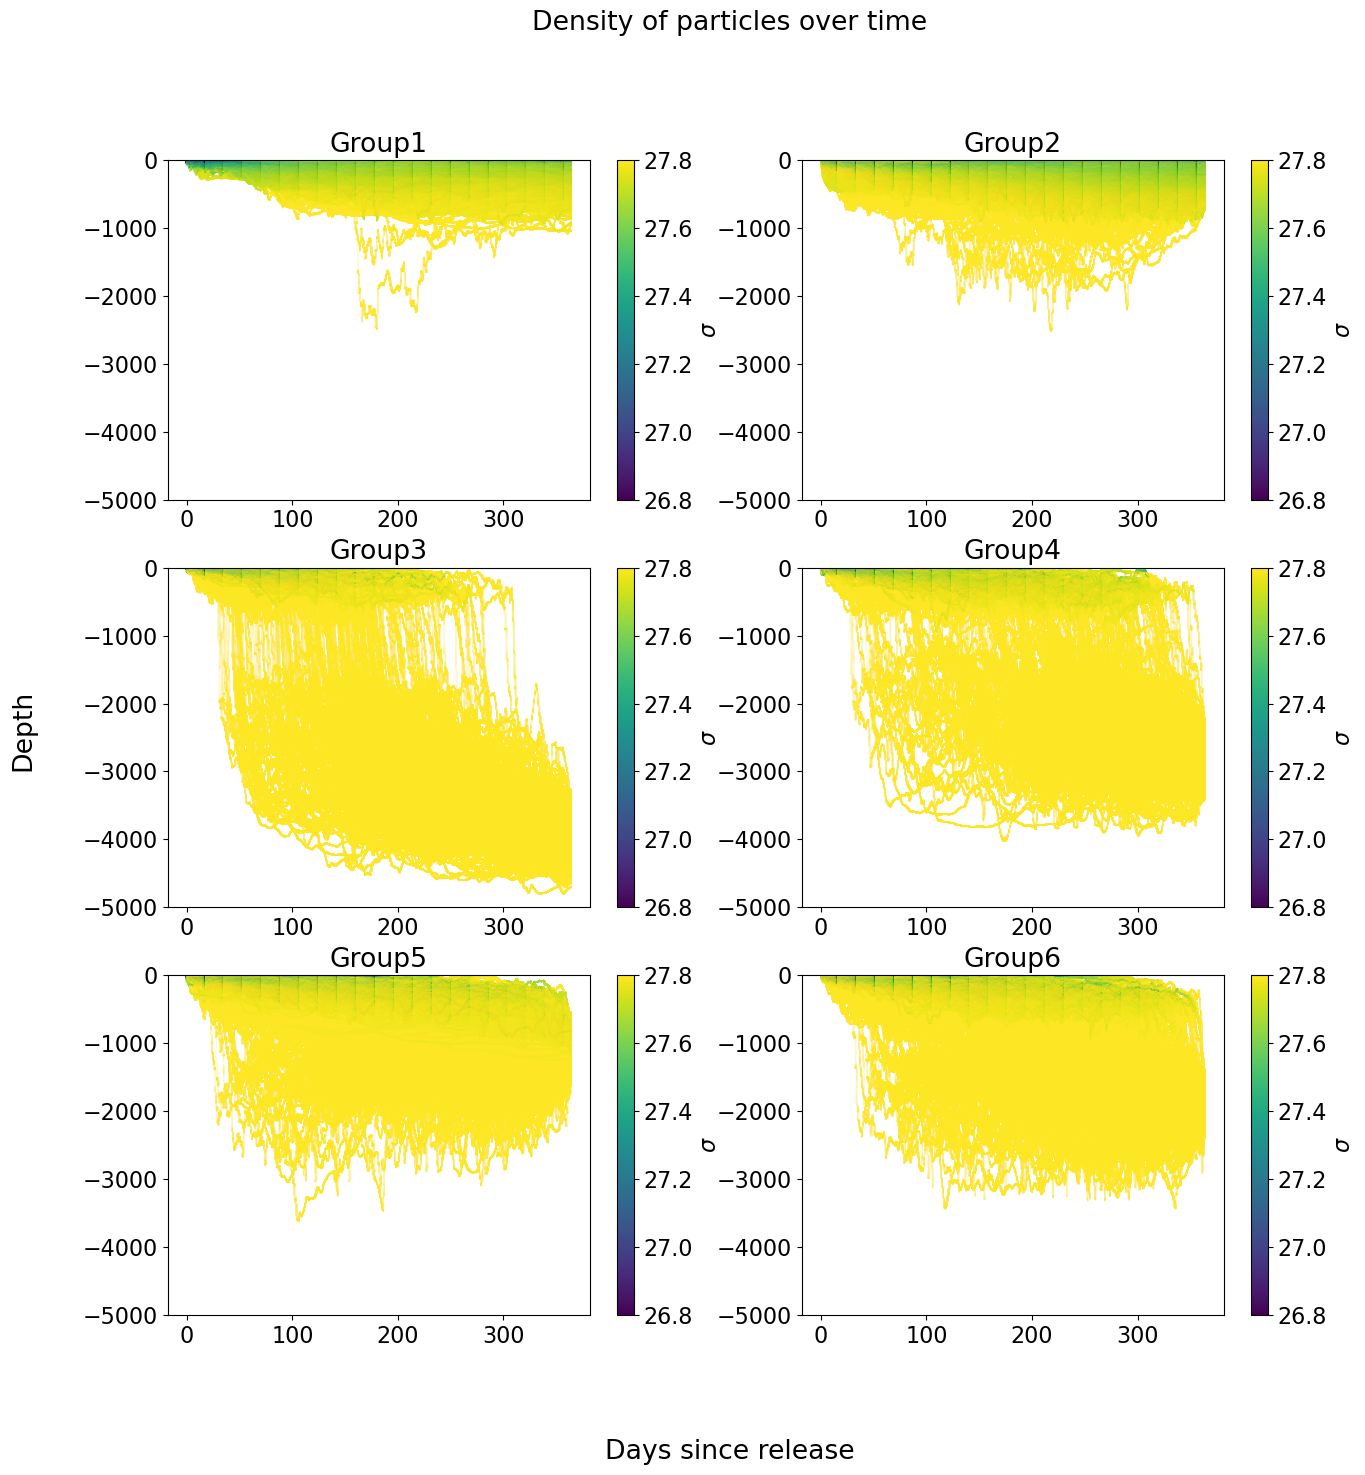

In [59]:
# plot rho with depth
time = temp.shape[0]
time = np.arange(0,time,1)
x_time0 = np.tile(time,(depth.shape[1],1))
x_time0 = x_time0.T   # this will be our time matrix to color the numbers
x_time0 = x_time0*900/86400
time1 = x_time0.astype(int)

fig = plt.figure(figsize=(15,15))
fig.tight_layout(pad=5.0)
plt.rcParams.update({'font.size': 16})
i = 1

fig.suptitle("Density of particles over time")
fig.supxlabel('Days since release')
fig.supylabel('Depth')

for group in groups:
    print(i)
    ax = fig.add_subplot(3, 2, i)
    plt.ylim(-5000, 0)
    plt.scatter(time1[:,group],depth[:,group],marker=".",s=0.01,c=rho_pot0[:,group],vmin=26.8,vmax=27.8)
    plt.title("Group"+str(i))
    plt.colorbar(label=''r'$\sigma$')
    i += 1
# plt.show()
plt.savefig("/scratch/project_2000789/muramarg/KMeans/formeeting_328/rho_over_time_new.png", dpi=300)

In [22]:
# seasonal distributions of the groups
# this says months but really it is a distribution of them by 13 4-week intervals
# find the repeating releases for each of the 105 points
month_idx = np.arange(0,52) #(13,8760)
x = 0
m = 1
for i in range(len(month_idx)):
    month_idx[i] = m
    
    x += 1
    if x == 4:
        x = 0
        m += 1
# repeat this for the 105 points
df_months_i = np.array([])
for i in range(105):
    df_months_i = np.append(df_months_i,month_idx)

unique, counts = np.unique(df_months_i, return_counts=True)
print(unique,counts)

df_months_i[df_months_i==13].shape

for group in groups:
    print(df_months_i[group][df_months_i[group] == 13].shape)

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13.] [420 420 420 420 420 420 420 420 420 420 420 420 420]
(85,)
(269,)
(15,)
(15,)
(19,)
(17,)


In [29]:
df_months_i.shape

(5460,)

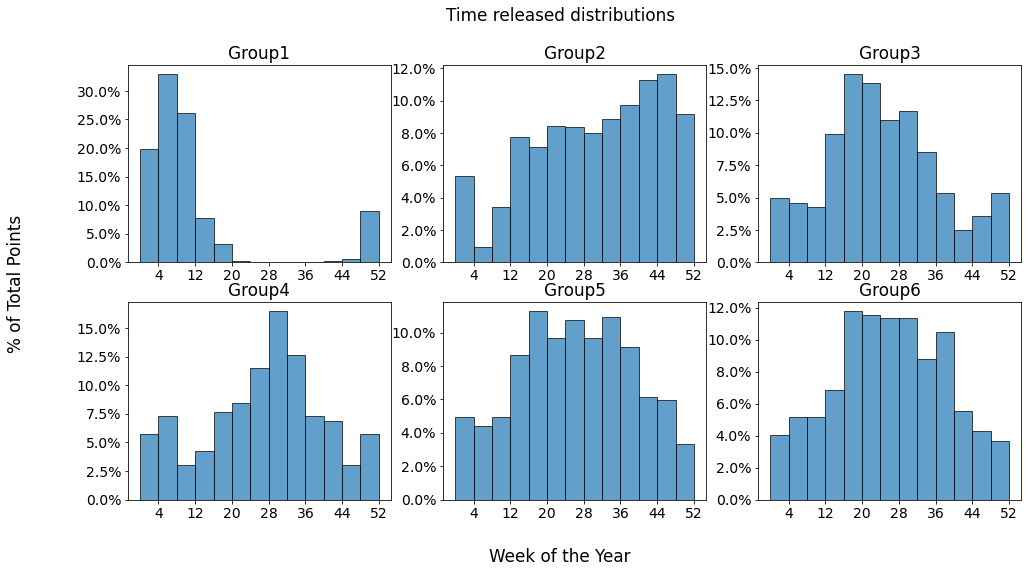

In [42]:
# # Distribution of Various Quantities
from matplotlib.ticker import PercentFormatter

fig = plt.figure(figsize = (16,8))
plt.tight_layout()
plt.rcParams.update({'font.size': 14})
plt.suptitle("Time released distributions")
fig.supxlabel('Week of the Year')
fig.supylabel('% of Total Points')
i = 1


for group in groups:
    ax = fig.add_subplot(2, 3, i)
    #plt.xlim(xmin=0, xmax = 2000)
    #ax.hist(df[thisfig][group].values,alpha=0.7,edgecolor="black")
    #ax.set_ylim([0,320])
    ax.hist(df_months_i[group],alpha=0.7,edgecolor="black",bins=[1,2,3,4,5,6,7,8,9,10,11,12,13,14],weights=np.ones(len(df_months_i[group])) / len(df_months_i[group]))
    mystr = "Group" + str(i)
    plt.xticks(ticks=[2,4,6,8,10,12,14],labels=[4,12,20,28,36,44,52])
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.xticks()
    plt.title(mystr)
    i  += 1
    
plt.savefig("/scratch/project_2000789/muramarg/KMeans/formeeting_3_8/months_dist_perc.png", dpi=300)

### Eulerian view of the particles

In [119]:
wm_arr = np.fromfile("/scratch/project_2000789/muramarg/KMeans/text_files/test_wmt.txt",sep=",")
wm_arr = wm_arr.reshape((35040,5460))

In [ ]:
# flatten the groups to see what colors are in them
print(set(wmt[:,group0].flatten()))
print(set(wmt[:,group1].flatten()))
print(set(wmt[:,group2].flatten()))
print(set(wmt[:,group3].flatten()))
print(set(wmt[:,group4].flatten()))
print(set(wmt[:,group5].flatten()))

In [35]:
cmap = ListedColormap(["tab:blue", "tab:orange", "tab:green", "tab:red","tab:purple","tab:brown","tab:olive"])

In [ ]:
# THESE ARE IN GRID POINTS
# plot all the groups colored by the water mass grid
proj = ccrs.SouthPolarStereo(central_longitude=0.0, true_scale_latitude=None, globe=None)
fig = plt.figure(figsize=(15,15))
#ax = fig.add_subplot(1, 1, 1,projection=proj)

# group0
ax = fig.add_subplot(2, 3, 1,projection=proj)
plt.rcParams.update({'font.size': 15})
plt.title("Group 1: "+ str(len(group0)))
plt.scatter(long2[:,group0],lat2[:,group0],marker='.',s=0.1,zorder=10,c=wmt[:,group0],cmap=cmap,transform=ccrs.PlateCarree())
labels=["AABW","mCDW","ISW","DSW","AASW","WW","mSW"]
cbar = plt.colorbar(ticks=[0,1,2,3,4,5,6])
cbar.ax.set_yticklabels(labels)
plt.pcolormesh(dg.lon_rho,dg.lat_rho,ds1.h.isel(),transform=ccrs.PlateCarree(),cmap=plt.get_cmap('gray'),alpha=0.7)
plt.grid()
ax.coastlines(zorder=5,facecolor='white',edgecolor='white')
cs = plt.contour(dg.lon_rho[300:,350:], dg.lat_rho[300:,350:],dg.h[300:,350:],levels=[1000],zorder=2, linestyles='solid', transform=ccrs.PlateCarree(), colors="black",alpha=0.5)
ax = plt.gca()
ax.gridlines(draw_labels=True,zorder=10,color="dimgray",alpha=0.5,transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND,facecolor='darkgray',zorder=3)
plt.xlim([1250000,2850000])
plt.ylim([250000,2350000])

# group1
ax = fig.add_subplot(2, 3, 2,projection=proj)
plt.rcParams.update({'font.size': 15})
plt.title("Group 2: "+ str(len(group1)))
plt.scatter(long2[:,group1],lat2[:,group1],marker='.',s=0.1,zorder=10,c=wmt[:,group1],cmap=cmap,transform=ccrs.PlateCarree())
labels=["AABW","mCDW","ISW","DSW","AASW","WW","mSW"]
cbar = plt.colorbar(ticks=[0,1,2,3,4,5,6])
cbar.ax.set_yticklabels(labels)
plt.pcolormesh(dg.lon_rho,dg.lat_rho,ds1.h.isel(),transform=ccrs.PlateCarree(),cmap=plt.get_cmap('gray'),alpha=0.7)
plt.grid()
ax.coastlines(zorder=5,facecolor='white',edgecolor='white')
cs = plt.contour(dg.lon_rho[300:,350:], dg.lat_rho[300:,350:],dg.h[300:,350:],levels=[1000],zorder=2, linestyles='solid', transform=ccrs.PlateCarree(), colors="black",alpha=0.5)
ax = plt.gca()
ax.gridlines(draw_labels=True,zorder=10,color="dimgray",alpha=0.5,transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND,facecolor='darkgray',zorder=3)
plt.xlim([1250000,2850000])
plt.ylim([250000,2350000])

# group2
ax = fig.add_subplot(2, 3, 3,projection=proj)
plt.rcParams.update({'font.size': 15})
plt.title("Group 3: "+ str(len(group2)))
plt.scatter(long2[:,group2],lat2[:,group2],marker='.',s=0.1,zorder=10,c=wmt[:,group2],cmap=cmap,transform=ccrs.PlateCarree())
labels=["AABW","mCDW","ISW","DSW","AASW","WW","mSW"]
cbar = plt.colorbar(ticks=[0,1,2,3,4,5,6])
cbar.ax.set_yticklabels(labels)
plt.pcolormesh(dg.lon_rho,dg.lat_rho,ds1.h.isel(),transform=ccrs.PlateCarree(),cmap=plt.get_cmap('gray'),alpha=0.7)
plt.grid()
ax.coastlines(zorder=5,facecolor='white',edgecolor='white')
cs = plt.contour(dg.lon_rho[300:,350:], dg.lat_rho[300:,350:],dg.h[300:,350:],levels=[1000],zorder=2, linestyles='solid', transform=ccrs.PlateCarree(), colors="black",alpha=0.5)
ax = plt.gca()
ax.gridlines(draw_labels=True,zorder=10,color="dimgray",alpha=0.5,transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND,facecolor='darkgray',zorder=3)
plt.xlim([1250000,2850000])
plt.ylim([250000,2350000])

# group3
ax = fig.add_subplot(2, 3, 4,projection=proj)
plt.rcParams.update({'font.size': 15})
plt.title("Group 4: "+ str(len(group3)))
plt.scatter(long2[:,group3],lat2[:,group3],marker='.',s=0.1,zorder=10,c=wmt[:,group3],cmap=cmap,transform=ccrs.PlateCarree())
labels=["AABW","mCDW","ISW","DSW","AASW","WW","mSW"]
cbar = plt.colorbar(ticks=[0,1,2,3,4,5,6])
cbar.ax.set_yticklabels(labels)
plt.pcolormesh(dg.lon_rho,dg.lat_rho,ds1.h.isel(),transform=ccrs.PlateCarree(),cmap=plt.get_cmap('gray'),alpha=0.7)
plt.grid()
ax.coastlines(zorder=5,facecolor='white',edgecolor='white')
cs = plt.contour(dg.lon_rho[300:,350:], dg.lat_rho[300:,350:],dg.h[300:,350:],levels=[1000],zorder=2, linestyles='solid', transform=ccrs.PlateCarree(), colors="black",alpha=0.5)
ax = plt.gca()
ax.gridlines(draw_labels=True,zorder=10,color="dimgray",alpha=0.5,transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND,facecolor='darkgray',zorder=3)
plt.xlim([1250000,2850000])
plt.ylim([250000,2350000])

# group4
ax = fig.add_subplot(2, 3, 5,projection=proj)
plt.rcParams.update({'font.size': 15})
plt.title("Group 5: "+ str(len(group4)))
plt.scatter(long2[:,group4],lat2[:,group4],marker='.',s=0.1,zorder=10,c=wmt[:,group4],cmap=cmap,transform=ccrs.PlateCarree())
labels=["AABW","mCDW","ISW","DSW","AASW","WW","mSW"]
cbar = plt.colorbar(ticks=[0,1,2,3,4,5,6])
cbar.ax.set_yticklabels(labels)
plt.pcolormesh(dg.lon_rho,dg.lat_rho,ds1.h.isel(),transform=ccrs.PlateCarree(),cmap=plt.get_cmap('gray'),alpha=0.7)
plt.grid()
ax.coastlines(zorder=5,facecolor='white',edgecolor='white')
cs = plt.contour(dg.lon_rho[300:,350:], dg.lat_rho[300:,350:],dg.h[300:,350:],levels=[1000],zorder=2, linestyles='solid', transform=ccrs.PlateCarree(), colors="black",alpha=0.5)
ax = plt.gca()
ax.gridlines(draw_labels=True,zorder=10,color="dimgray",alpha=0.5,transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND,facecolor='darkgray',zorder=3)
plt.xlim([1250000,2850000])
plt.ylim([250000,2350000])

# group5
ax = fig.add_subplot(2, 3, 6,projection=proj)
plt.rcParams.update({'font.size': 15})
plt.title("Group 6: "+ str(len(group5)))
plt.scatter(long2[:,group5],lat2[:,group5],marker='.',s=0.1,zorder=10,c=wmt[:,group5],cmap=cmap,transform=ccrs.PlateCarree())
labels=["AABW","mCDW","ISW","DSW","AASW","WW","mSW"]
cbar = plt.colorbar(ticks=[0,1,2,3,4,5,6])
cbar.ax.set_yticklabels(labels)
plt.pcolormesh(dg.lon_rho,dg.lat_rho,ds1.h.isel(),transform=ccrs.PlateCarree(),cmap=plt.get_cmap('gray'),alpha=0.7)
plt.grid()
ax.coastlines(zorder=5,facecolor='white',edgecolor='white')
cs = plt.contour(dg.lon_rho[300:,350:], dg.lat_rho[300:,350:],dg.h[300:,350:],levels=[1000],zorder=2, linestyles='solid', transform=ccrs.PlateCarree(), colors="black",alpha=0.5)
ax = plt.gca()
ax.gridlines(draw_labels=True,zorder=10,color="dimgray",alpha=0.5,transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND,facecolor='darkgray',zorder=3)
plt.xlim([1250000,2850000])
plt.ylim([250000,2350000])

plt.savefig("/scratch/project_2000789/muramarg/KMeans/FINAL/wmt_colored_group_replaced.png", dpi=300)

Error in callback <function flush_figures at 0x7f06b303ab00> (for post_execute):


In [75]:
set(wmt[:,group0][20000])

{0.0, 1.0, 3.0, 4.0, 5.0, 6.0}

(250000.0, 2350000.0)

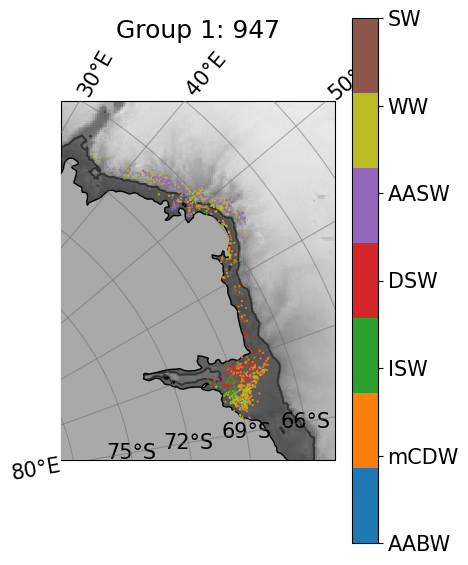

In [51]:
proj = ccrs.SouthPolarStereo(central_longitude=0.0, true_scale_latitude=None, globe=None)
fig = plt.figure(figsize=(15,15))
#ax = fig.add_subplot(1, 1, 1,projection=proj)

# group0
ax = fig.add_subplot(2, 3, 1,projection=proj)
plt.rcParams.update({'font.size': 15})
plt.title("Group 1: "+ str(len(group0)))
plt.scatter(long2[:,group0][20000],lat2[:,group0][20000],marker='.',s=1,zorder=10,c=mass2[group0],cmap=cmap,transform=ccrs.PlateCarree())
labels=["AABW","mCDW","ISW","DSW","AASW","WW","SW"]
cbar = plt.colorbar(ticks=[0,1,2,3,4,5,6])
cbar.ax.set_yticklabels(labels)
plt.pcolormesh(dg.lon_rho,dg.lat_rho,ds1.h.isel(),transform=ccrs.PlateCarree(),cmap=plt.get_cmap('gray'),alpha=0.7)
plt.grid()
ax.coastlines(zorder=5,facecolor='white',edgecolor='white')
cs = plt.contour(dg.lon_rho[300:,350:], dg.lat_rho[300:,350:],dg.h[300:,350:],levels=[1000],zorder=2, linestyles='solid', transform=ccrs.PlateCarree(), colors="black",alpha=0.5)
ax = plt.gca()
ax.gridlines(draw_labels=True,zorder=10,color="dimgray",alpha=0.5,transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND,facecolor='darkgray',zorder=3)
plt.xlim([1250000,2850000])
plt.ylim([250000,2350000])